# Explorative Datenanalyse Part 2

In [248]:
from rnaloops.data_explorer.import_helper import *
df = get_prepared_df()

## Übersicht der Daten

Laut website sind für die Loop Types folgende Anzahl an Strukturen vorhanden
- 3-way junction	33657
- 4-way junction	22518
- 5-way junction	12381
- 6-way junction	3679
- 7-way junction	4460
- 8-way junction	3131
- 9-way junction	1758
- 10-way junction	269
- 11-way junction	1836
- 12-way junction	147
- 13-way junction	52
- 14-way junction	373

Wir können das überprüfen:

In [2]:
our = df.groupby(['loop_type'])['loop_type'].count()
web = [33657, 22518, 12381, 3679, 4460, 3131, 1758, 269, 1836, 147, 52, 373]
print('Percentage of structures of different loop types that we can access:')
{key: x/y*100 for key, x, y in zip(our.index, our.values, web)}

Percentage of structures of different loop types that we can access:


{'03-way': 91.54410672371274,
 '04-way': 87.80975219824141,
 '05-way': 91.24464905904208,
 '06-way': 90.75835824952433,
 '07-way': 76.2780269058296,
 '08-way': 90.80166081124241,
 '09-way': 85.60864618885097,
 '10-way': 78.06691449814126,
 '11-way': 88.61655773420479,
 '12-way': 91.15646258503402,
 '13-way': 75.0,
 '14-way': 64.6112600536193}

Die meisten Strukturen (>90%) haben 8 oder weniger Stems. \
In diesem Bereich haben wir i.d.R. auch 90% der laut Autoren zur Verfügung stehenden Strukturen in unseren Daten. \
Nur bei 7-way junctions ist der Anteil deutlich kleiner (~76%), das sollten wir im vielleicht im Kopf behalten... \
Für die Analyse sind way-3 bis way-8 Strukturen also vermutlich am sinnvollsten, hier haben wir ausreichend Daten:

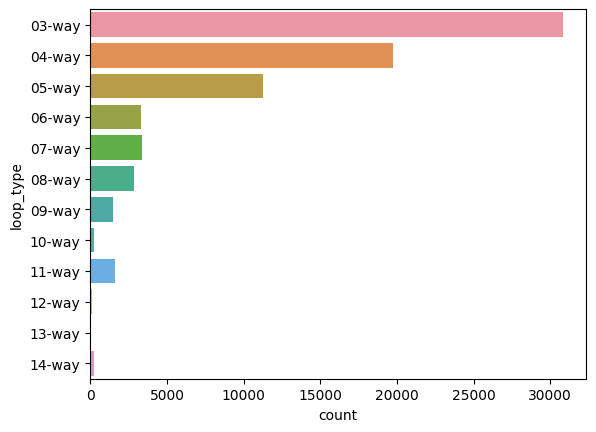

In [3]:
_ = sns.countplot(data=df, y='loop_type', orient='v')

Wir können auch die Verteilung auf die home_structure anschauen, aber hier gibt es zu viele um wirklich was zu erkennen:

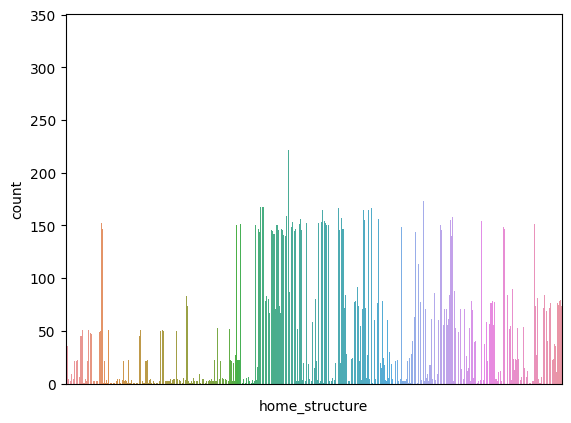

In [51]:
fig, ax = plt.subplots()
sns.countplot(data=df, x='home_structure', orient='h', ax=ax)
ax.set_xticklabels('')
_ = plt.tick_params(bottom = False)

## Verteilung einzelner Feature

Jetzt könnte z.B. die Verteilung der Längen von (1) connection Helix und (2) verbindende Strands, sowie die Verteilungen der Euler (3) und Planaren (4) Winkel dargestellt werden:

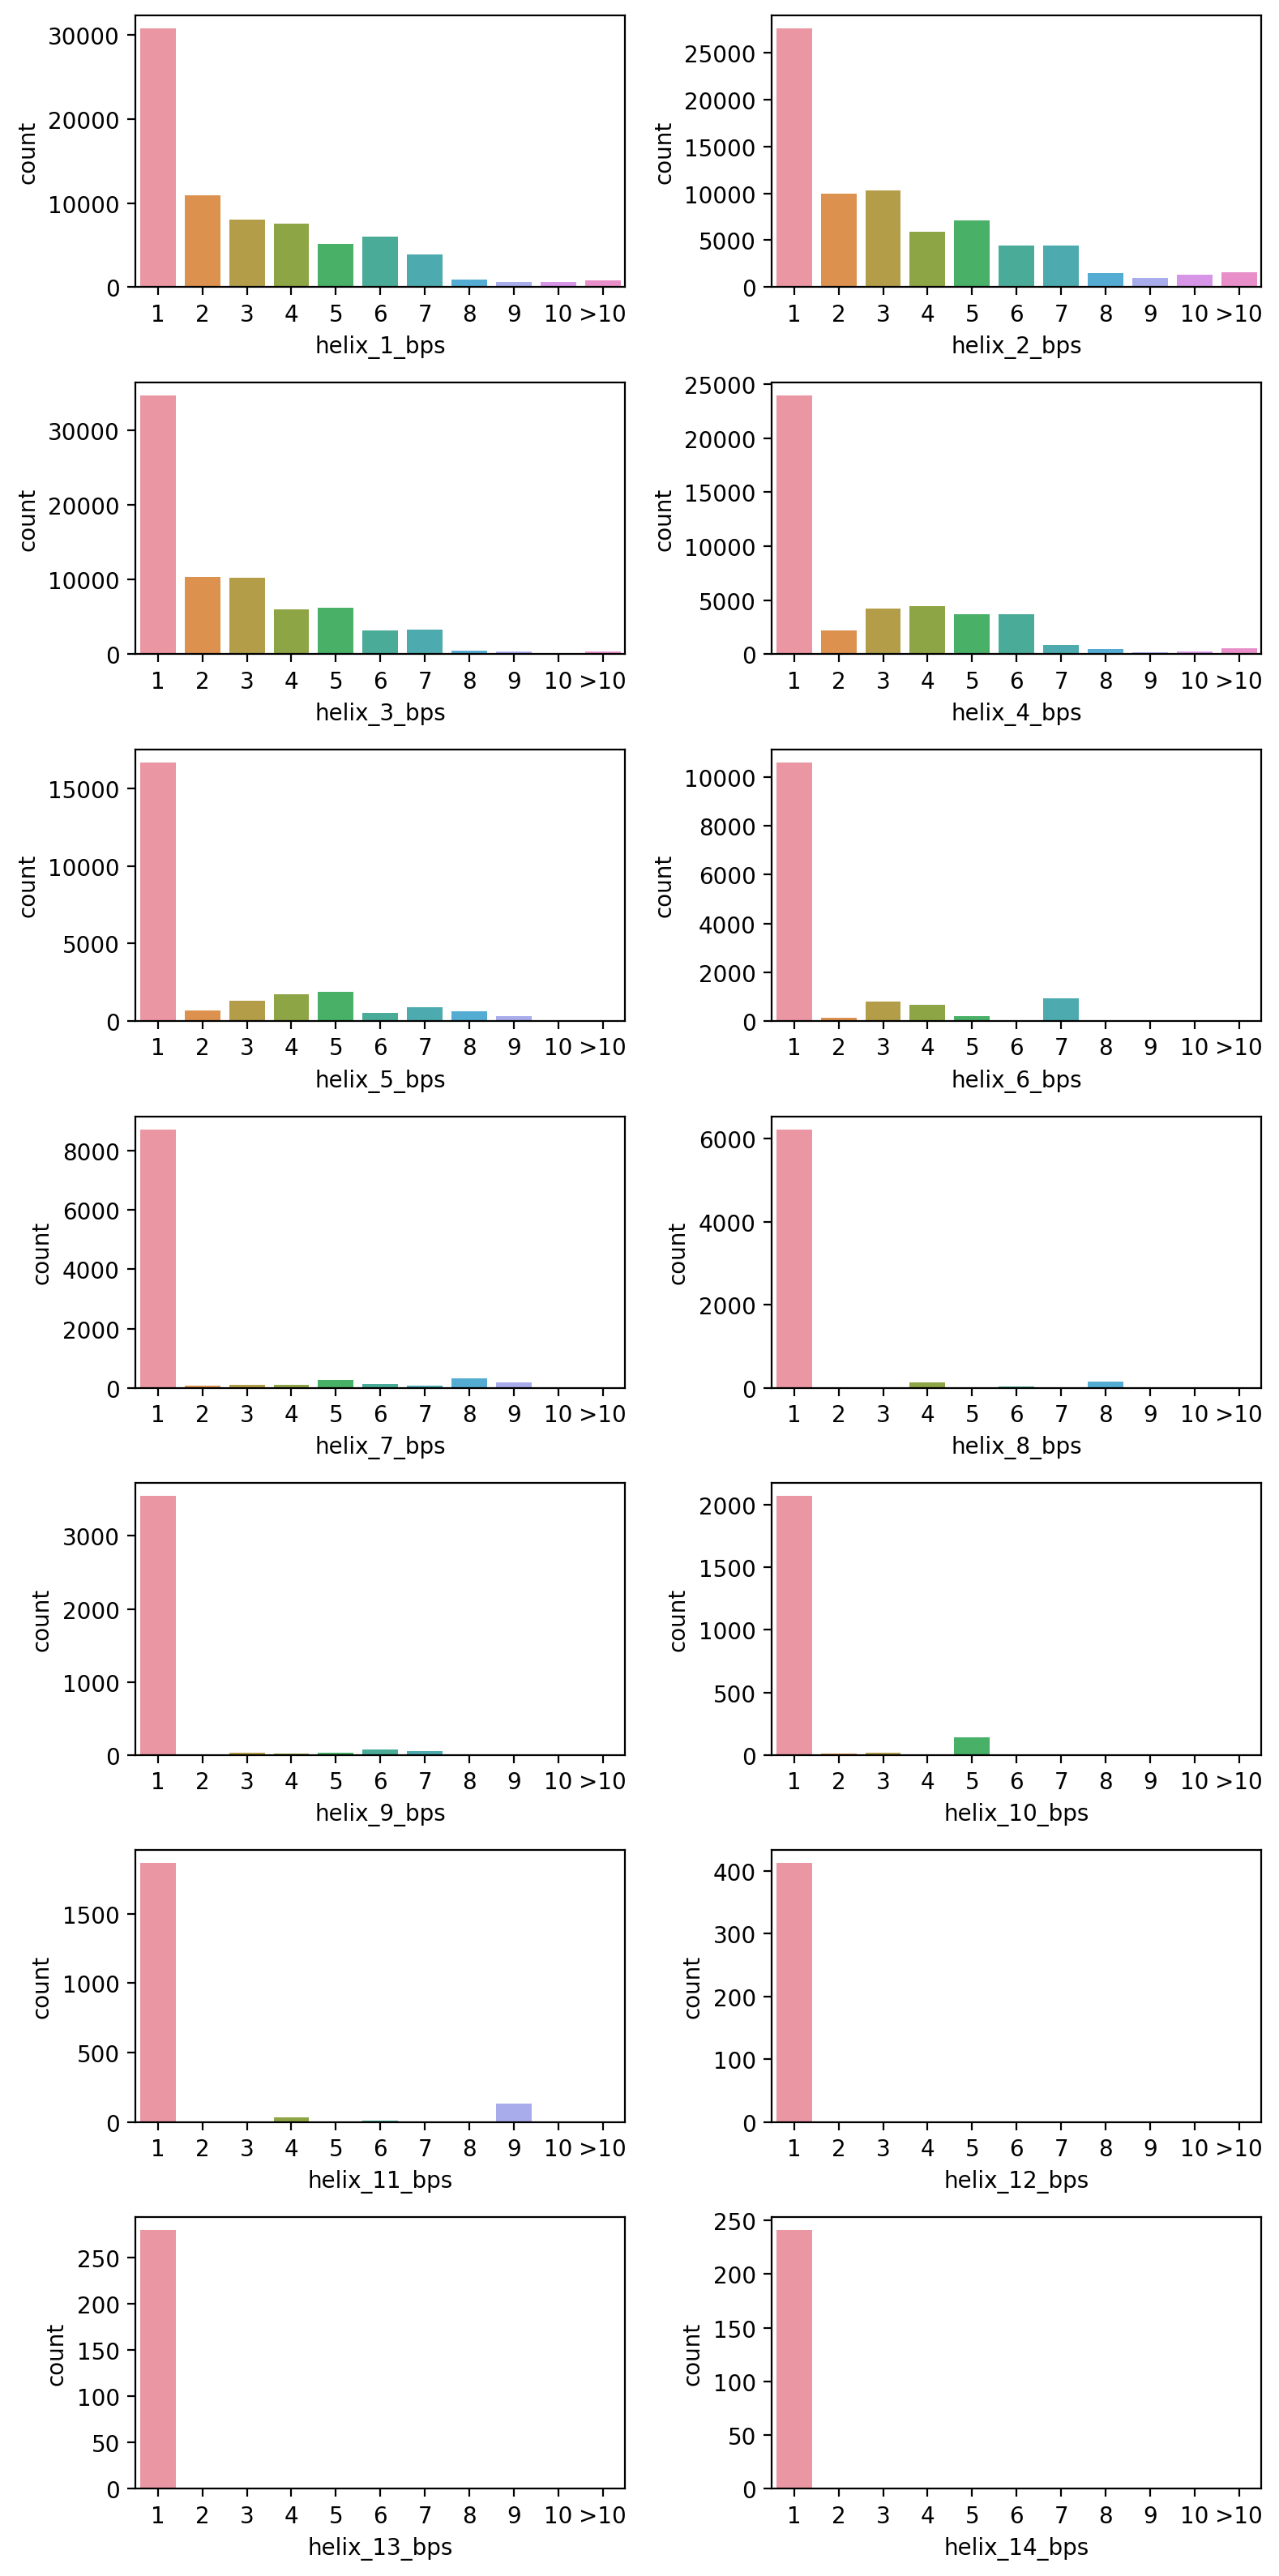

In [57]:
# (1) Verteilung der Helixlängen nach laufender Helixnummer:

fig, ax = plt.subplots(7, 2, figsize=(8, 16), dpi=200)

for idx, a in enumerate(ax.ravel()[:14]):
    
    key = f'helix_{idx+1}_bps'
    data = df[df[key]>0]
    data.loc[data[key]>10, key] = '>10'
    
    sns.countplot(data=data, x=key, ax=a, order=list(range(1, 11)) + ['>10'])
    
plt.tight_layout()

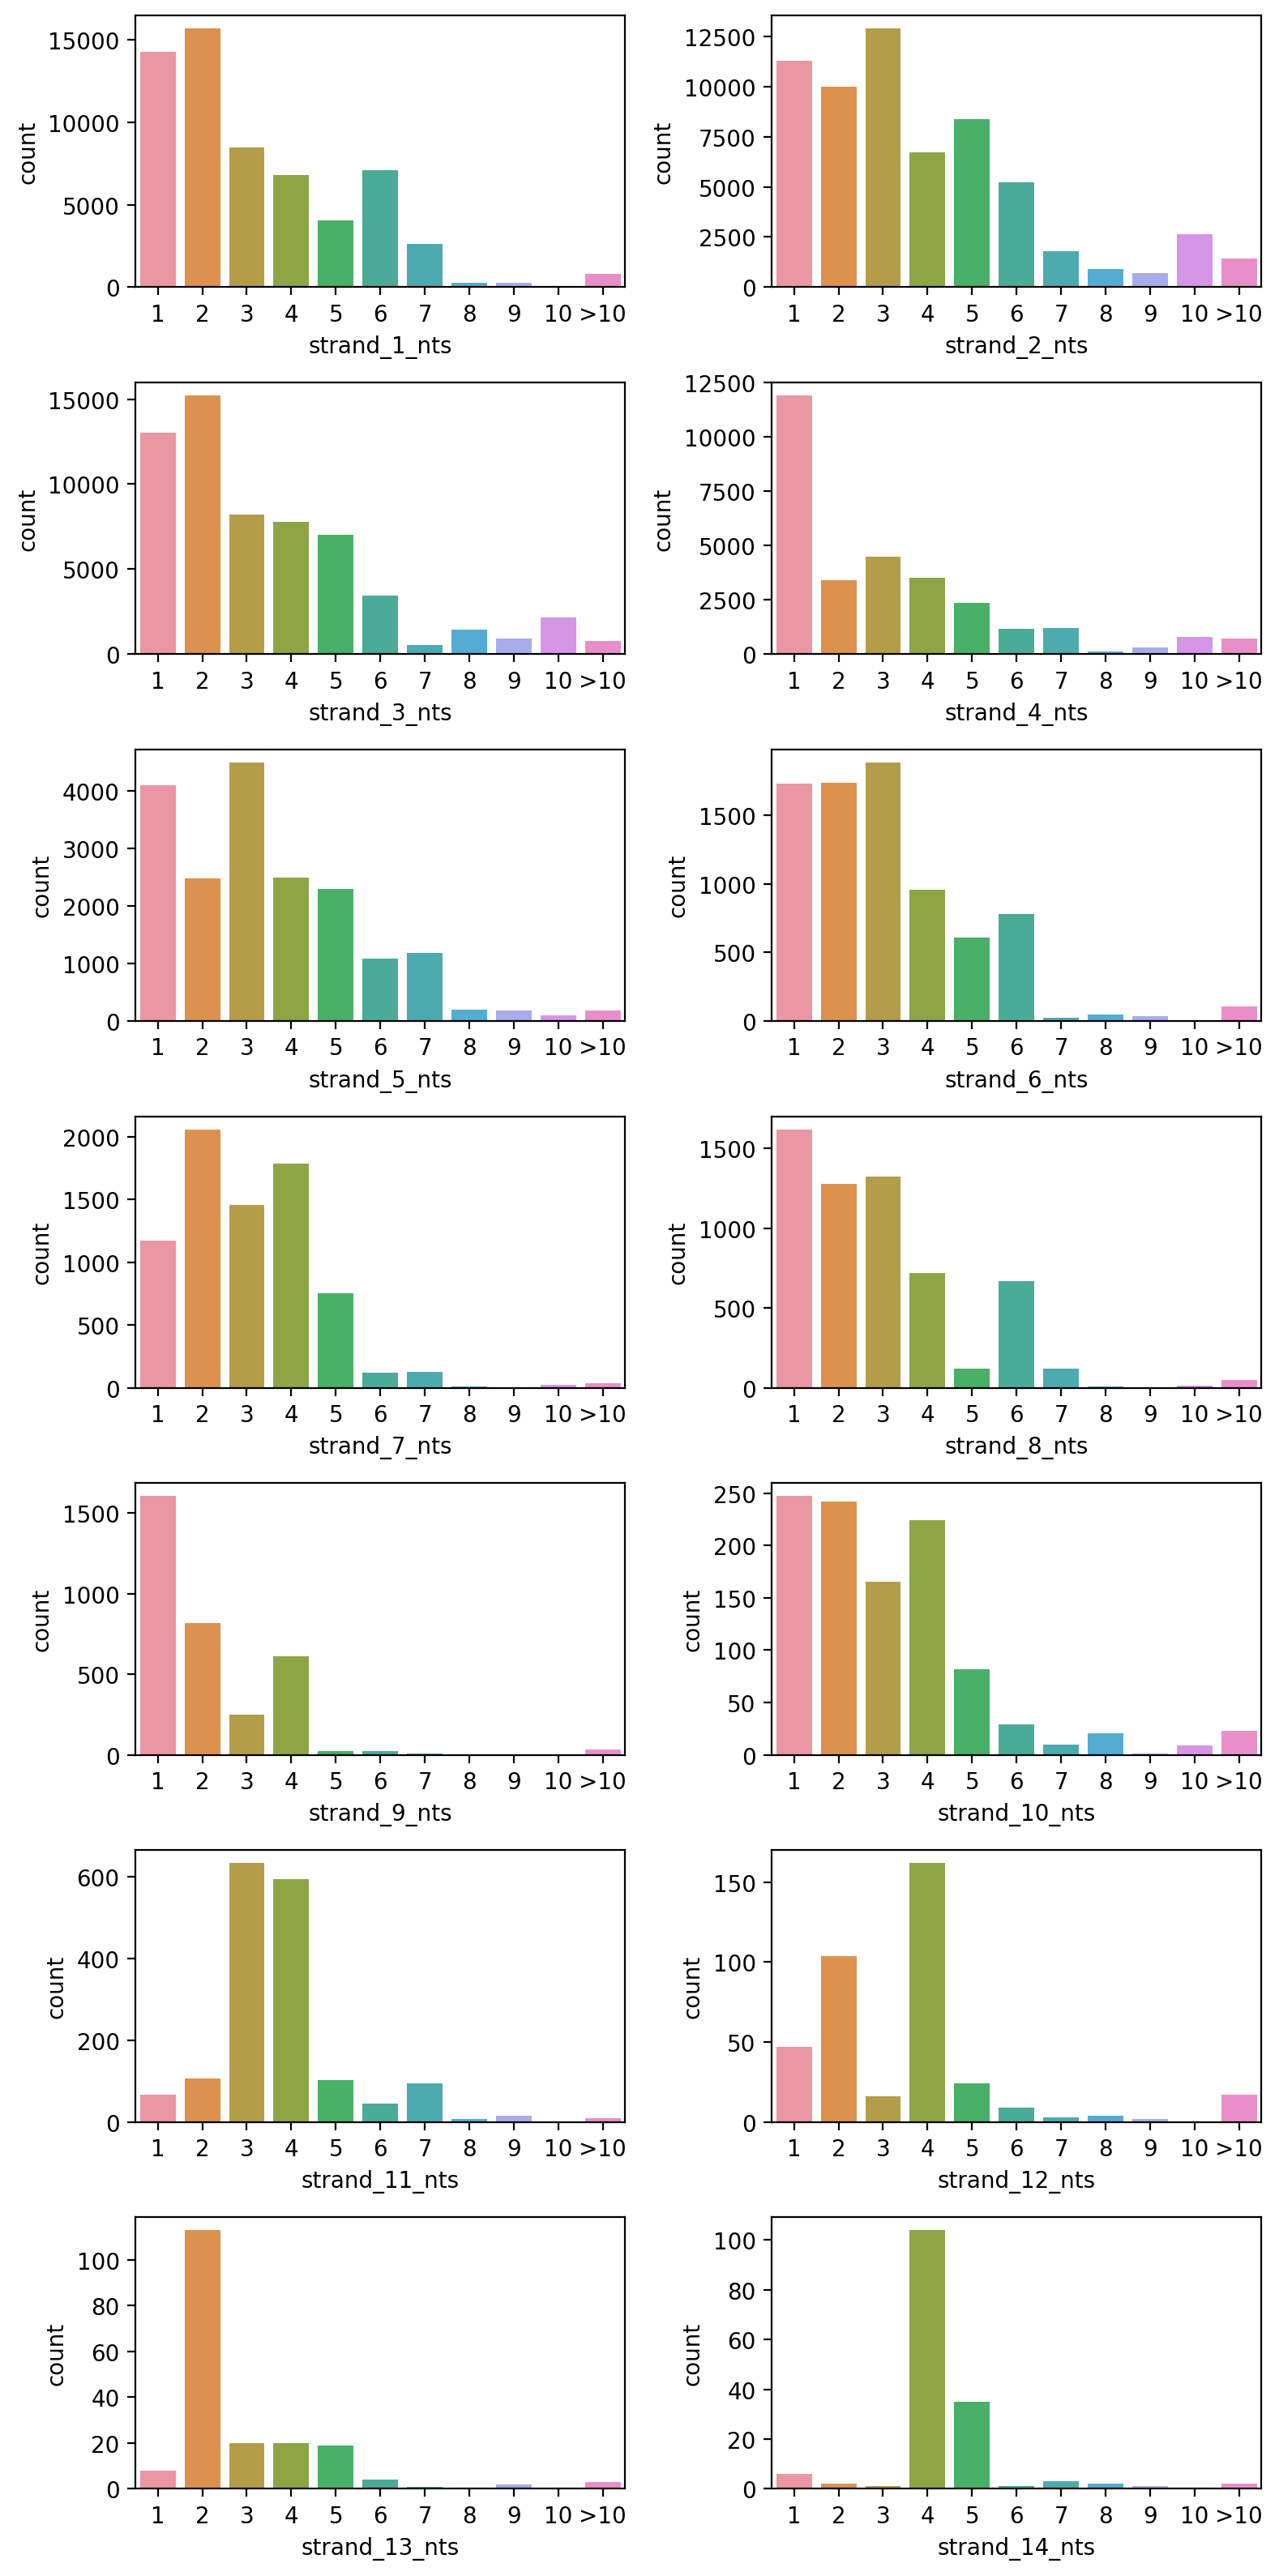

In [56]:
# (2) Verteilung der Strandlängen nach laufender Strandnummer:

fig, ax = plt.subplots(7, 2, figsize=(8, 16), dpi=200)

for idx, a in enumerate(ax.ravel()[:14]):
    
    key = f'strand_{idx+1}_nts'
    data = df[df[key]>0]
    data.loc[data[key]>10, key] = '>10'
    
    sns.countplot(data=data, x=key, ax=a, order=list(range(1, 11)) + ['>10'])
    
plt.tight_layout()

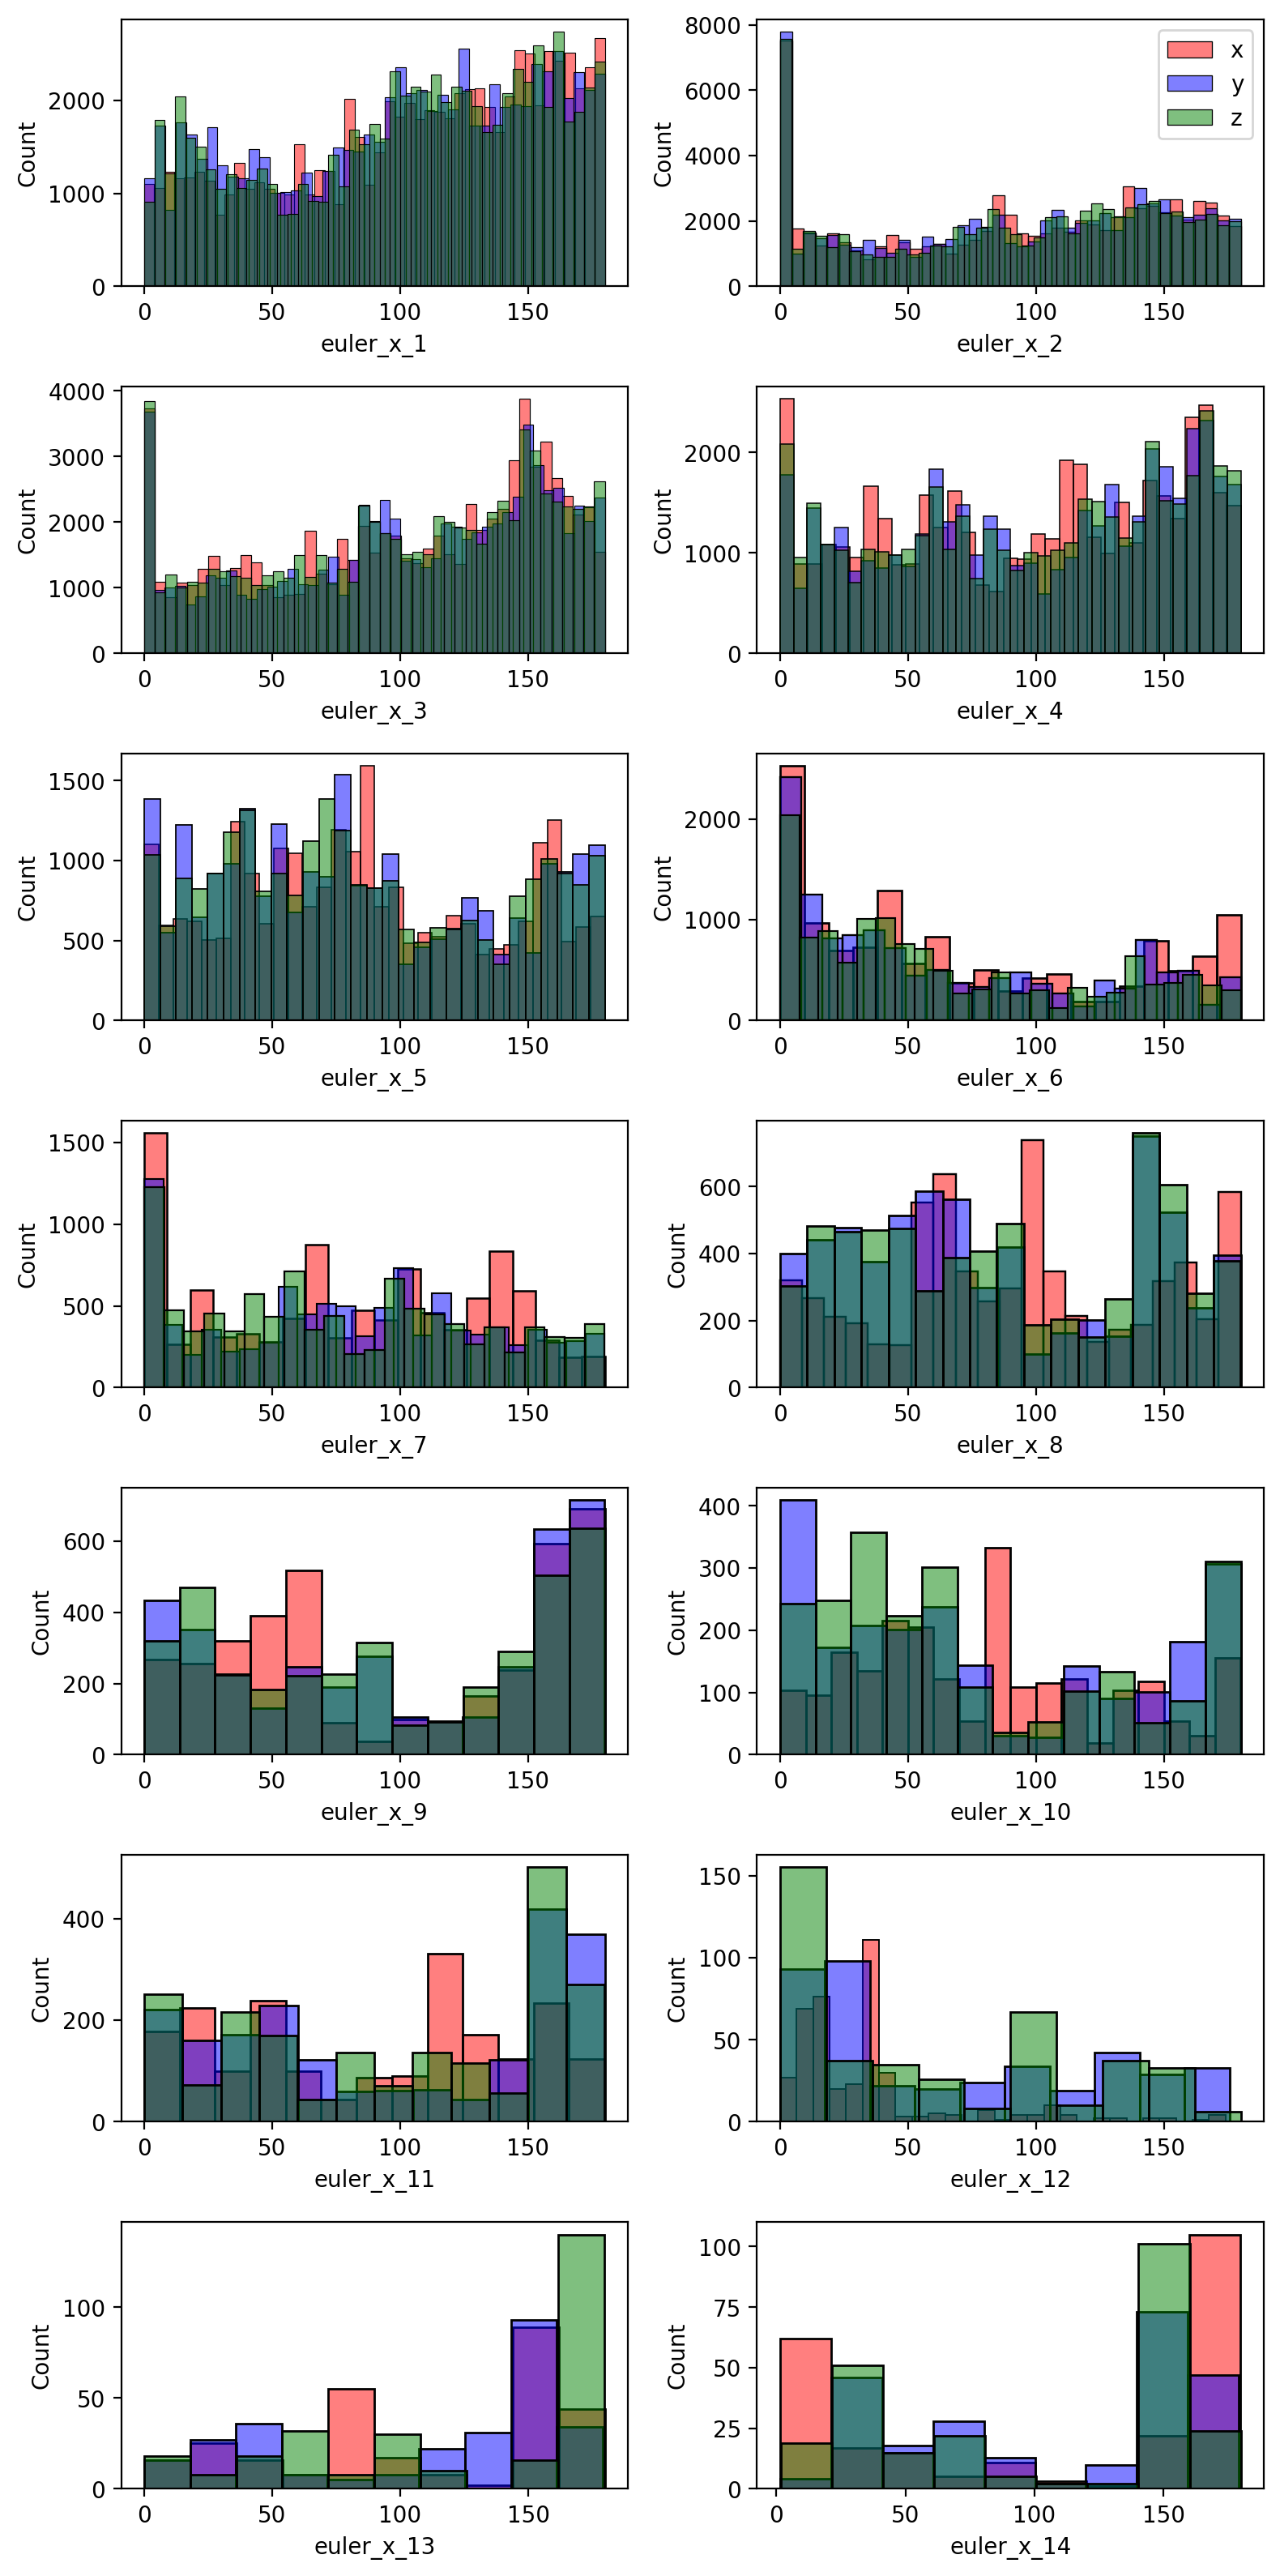

In [81]:
# (3) Verteilung der Eulerwinkel:

fig, ax = plt.subplots(7, 2, figsize=(8, 16), dpi=200)

for idx, a in enumerate(ax.ravel()[:14]):
    
    x = sns.histplot(data=df, x=f'euler_x_{idx+1}', ax=a, alpha=0.5, color='r')
    y = sns.histplot(data=df, x=f'euler_y_{idx+1}', ax=a, alpha=0.5, color='b')
    z = sns.histplot(data=df, x=f'euler_z_{idx+1}', ax=a, alpha=0.5, color='g')
    
    if idx == 1:
        a.legend(['x', 'y', 'z'])
    
plt.tight_layout()

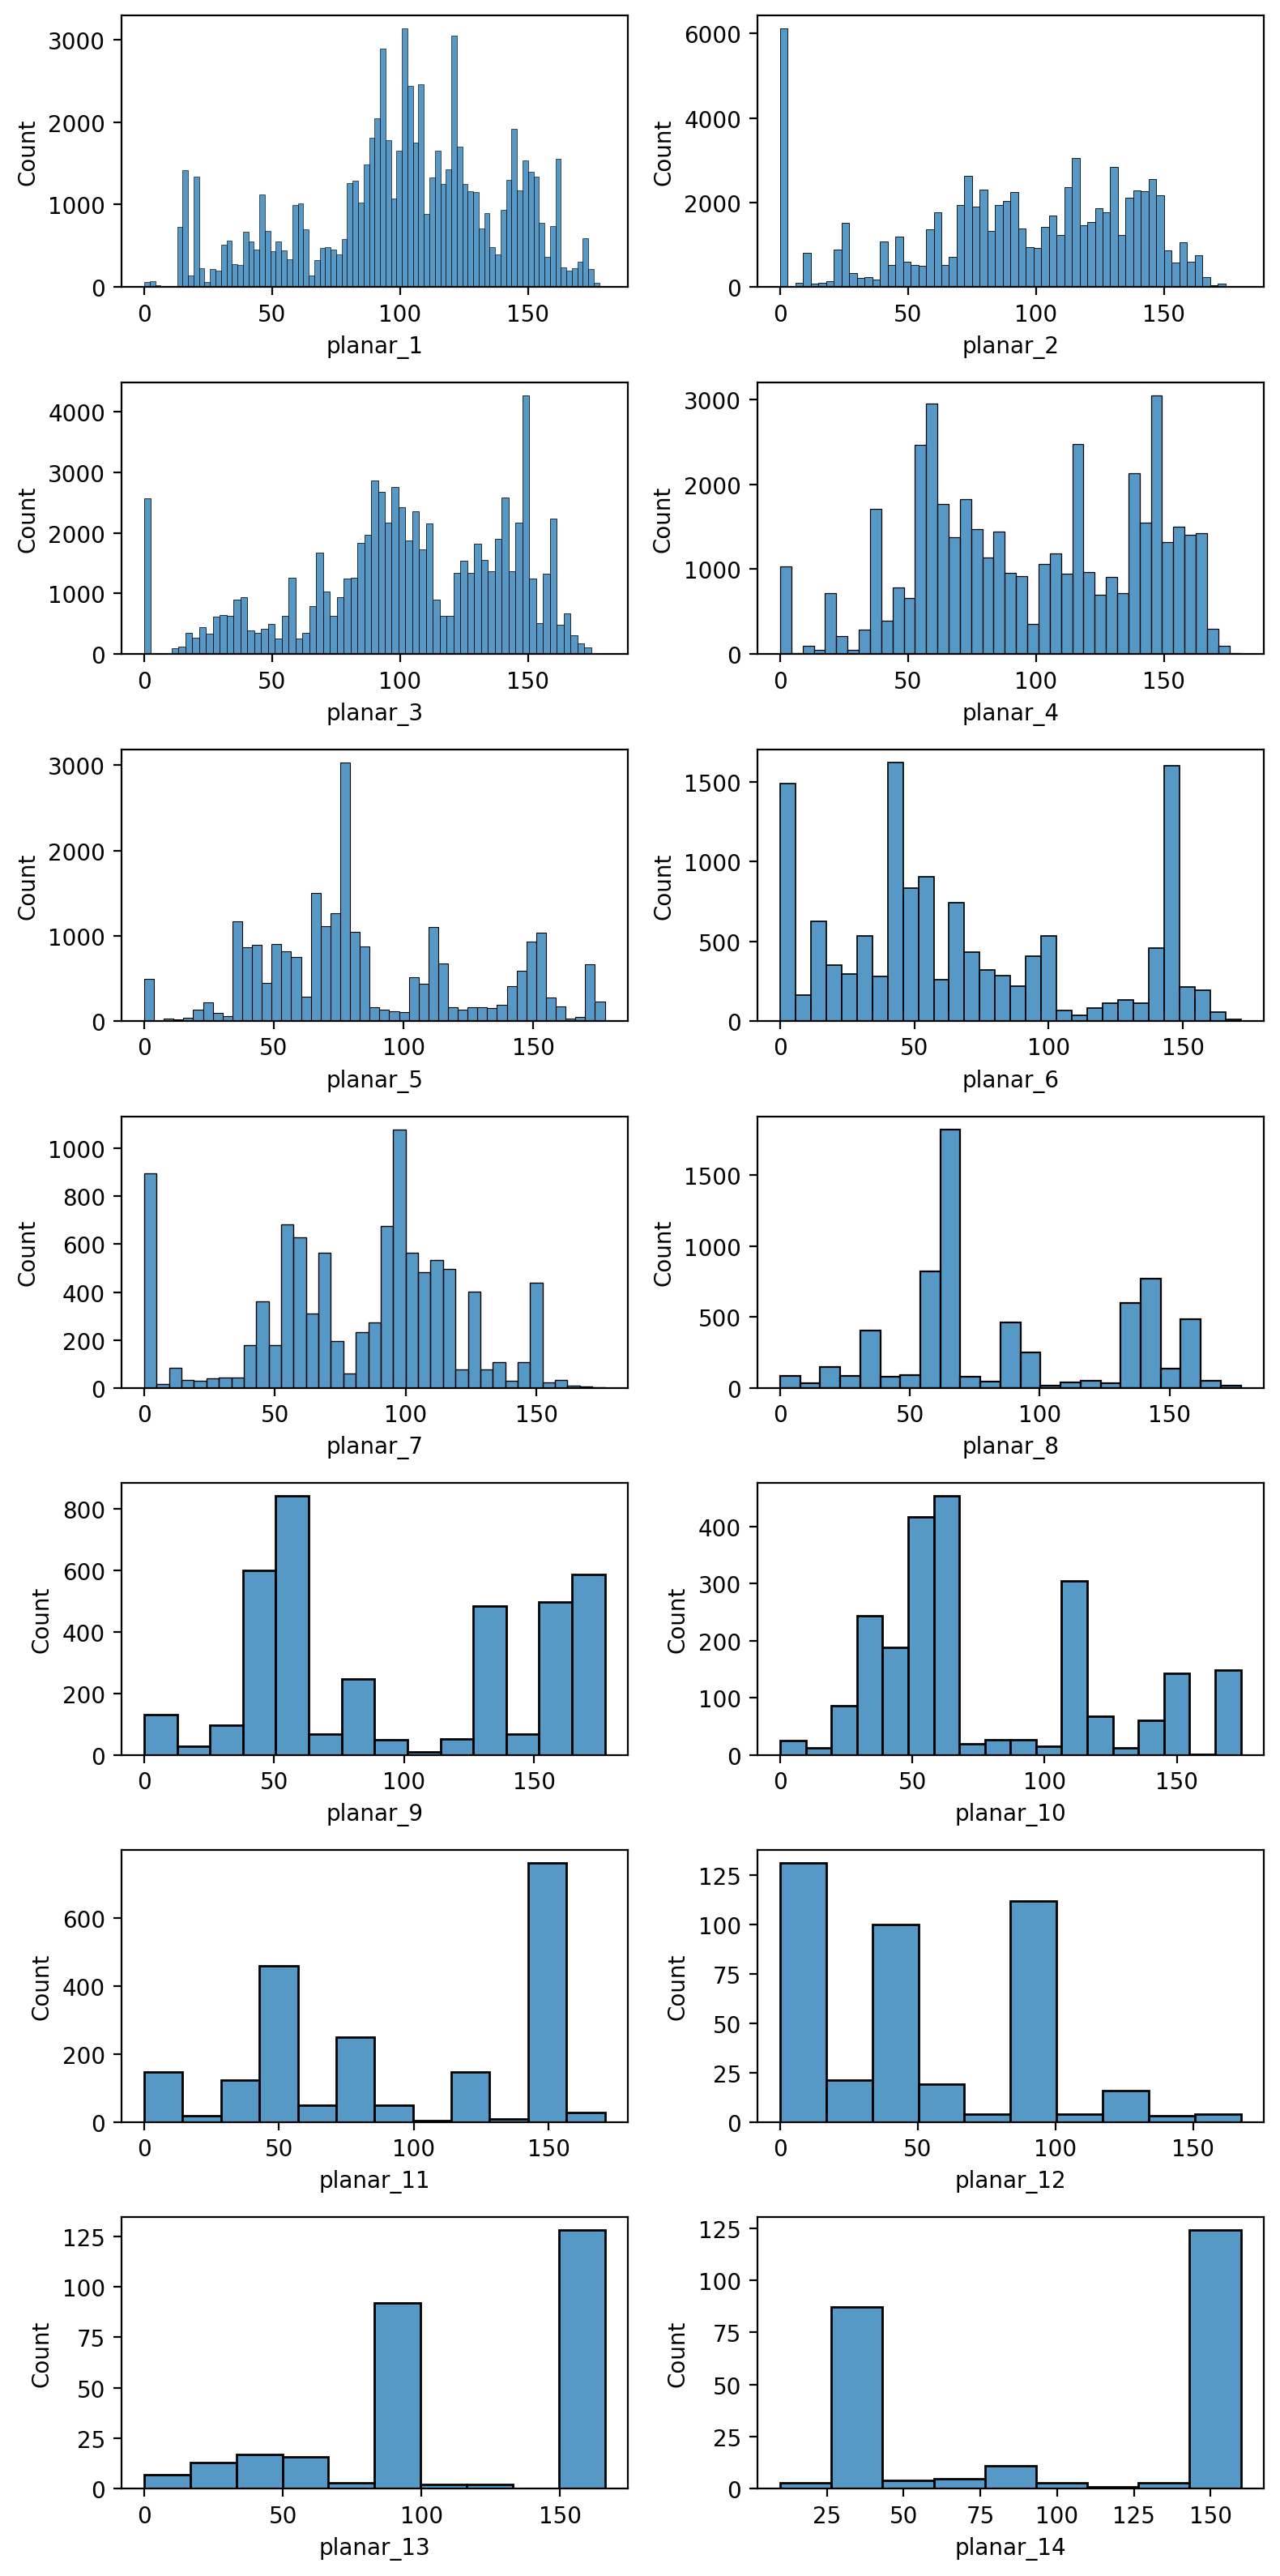

In [83]:
# (4) Verteilung der Planarwinkel:

fig, ax = plt.subplots(7, 2, figsize=(8, 16), dpi=200)

for idx, a in enumerate(ax.ravel()[:14]):
    
    x = sns.histplot(data=df, x=f'planar_{idx+1}', ax=a)
    
plt.tight_layout()

Man sieht schon ein paar Auffälligkeiten, die man diskutieren könnte. \
Interessant wäre noch zu sehen, wie die Verteilungen je nach loop-type aussehen, den haben wir in den Plots oben gar nicht berücksichtigt. \
Wir konzentrieren uns auf way-3 bis way-8, wobei noch zu diskutieren ist, ob wir den Rest wirklich komplett ignorieren:

In [225]:
df = df[df.loop_type.isin([f'{i:02}-way' for i in range(3, 9)])]
df.loop_type = df.loop_type.cat.remove_categories([f'{i:02}-way' 
                                                   for i in range(9, 15)])
df = df.drop([col for col in df.columns if any(str(x) in col 
                                               for x in range(9, 15))], axis=1)

## Verteilung von Featuren nach Loop-Typ

Wir können jetzt die einzelnen Helixlängen nach Loop Typen gruppieren und jeweils einen 2D Plot (Heatmap) erzeugen:

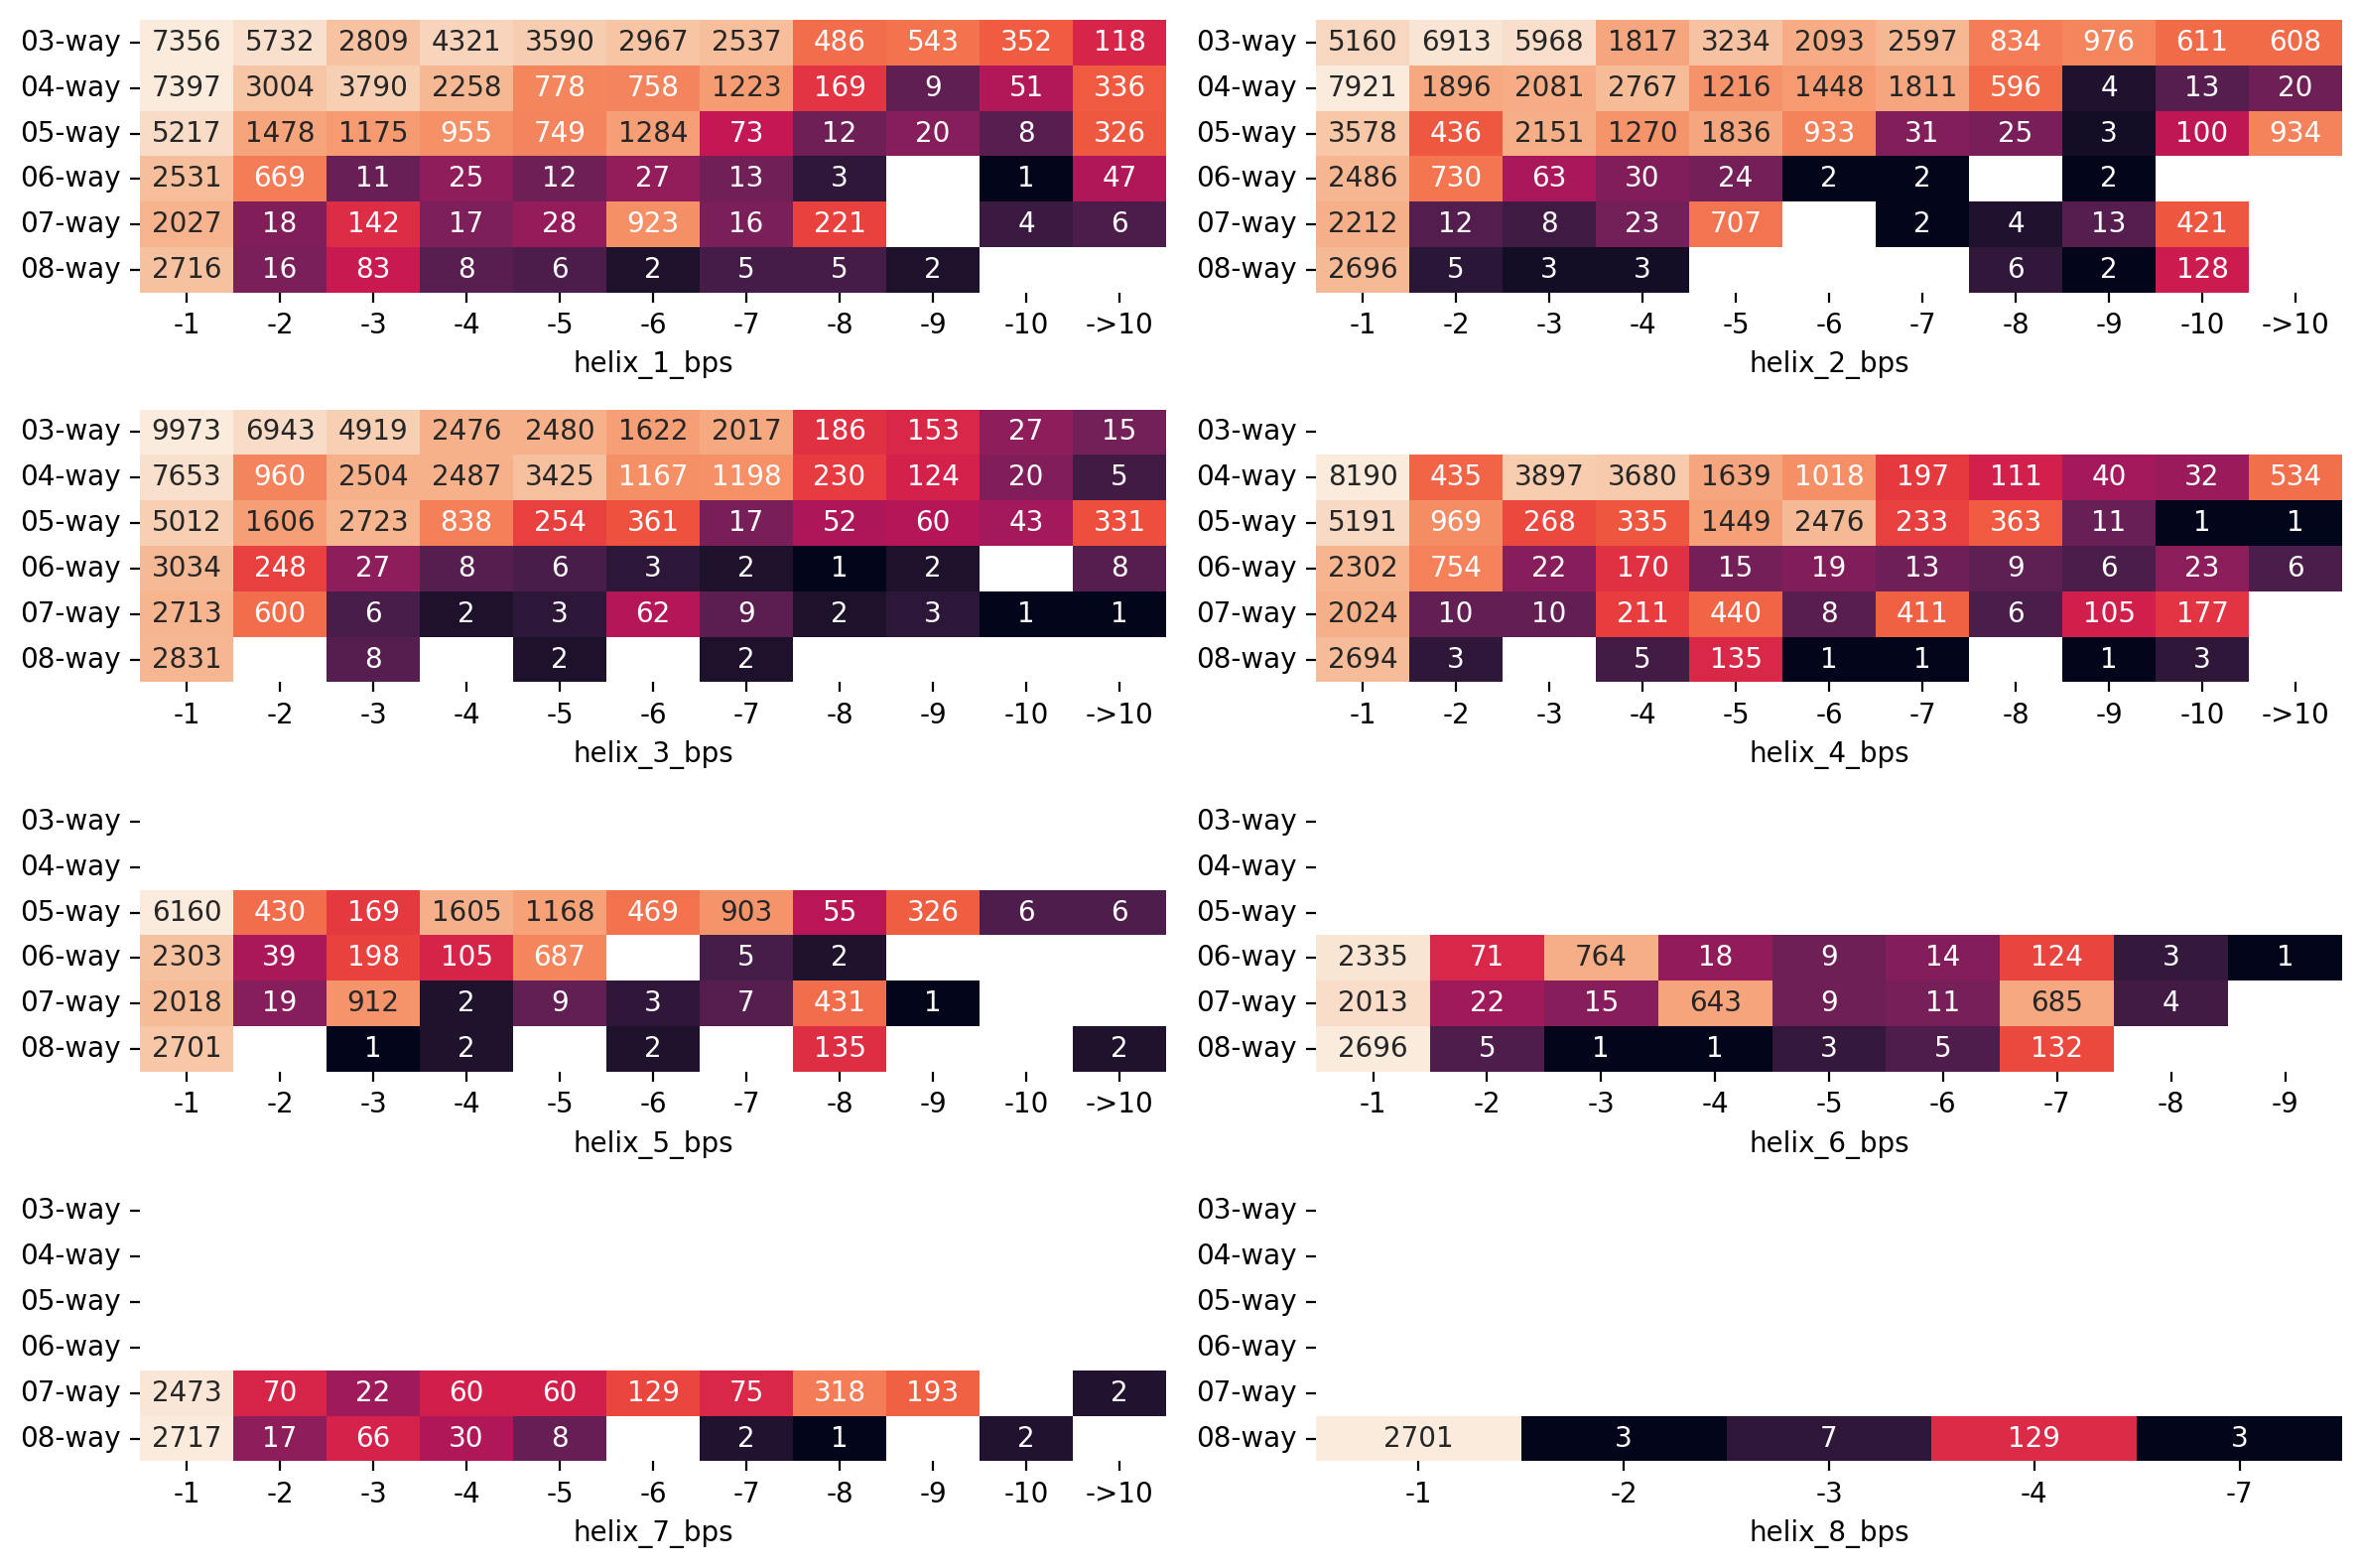

In [177]:
# (1) Verteilung der Helixlängen nach Looptyp:

fig, ax = plt.subplots(4, 2, figsize=(12, 8), dpi=200)

for idx, a in enumerate(ax.ravel()[:8]):
    
    key = f'helix_{idx+1}_bps'
    data = df[df[key]>0]
    data.loc[data[key]>10, key] = '>10'
    
    grouped = data.groupby(['loop_type', key]).count()
    matrix = grouped[['db_notation']].unstack(level=1)
    matrix = matrix.rename(columns={'db_notation': ''})
    
    sns.heatmap(matrix, norm=LogNorm(), annot=True, fmt='d', ax=a, cbar=False)
    a.set_xlabel(key)
    a.set(ylabel=None)
    
plt.tight_layout()

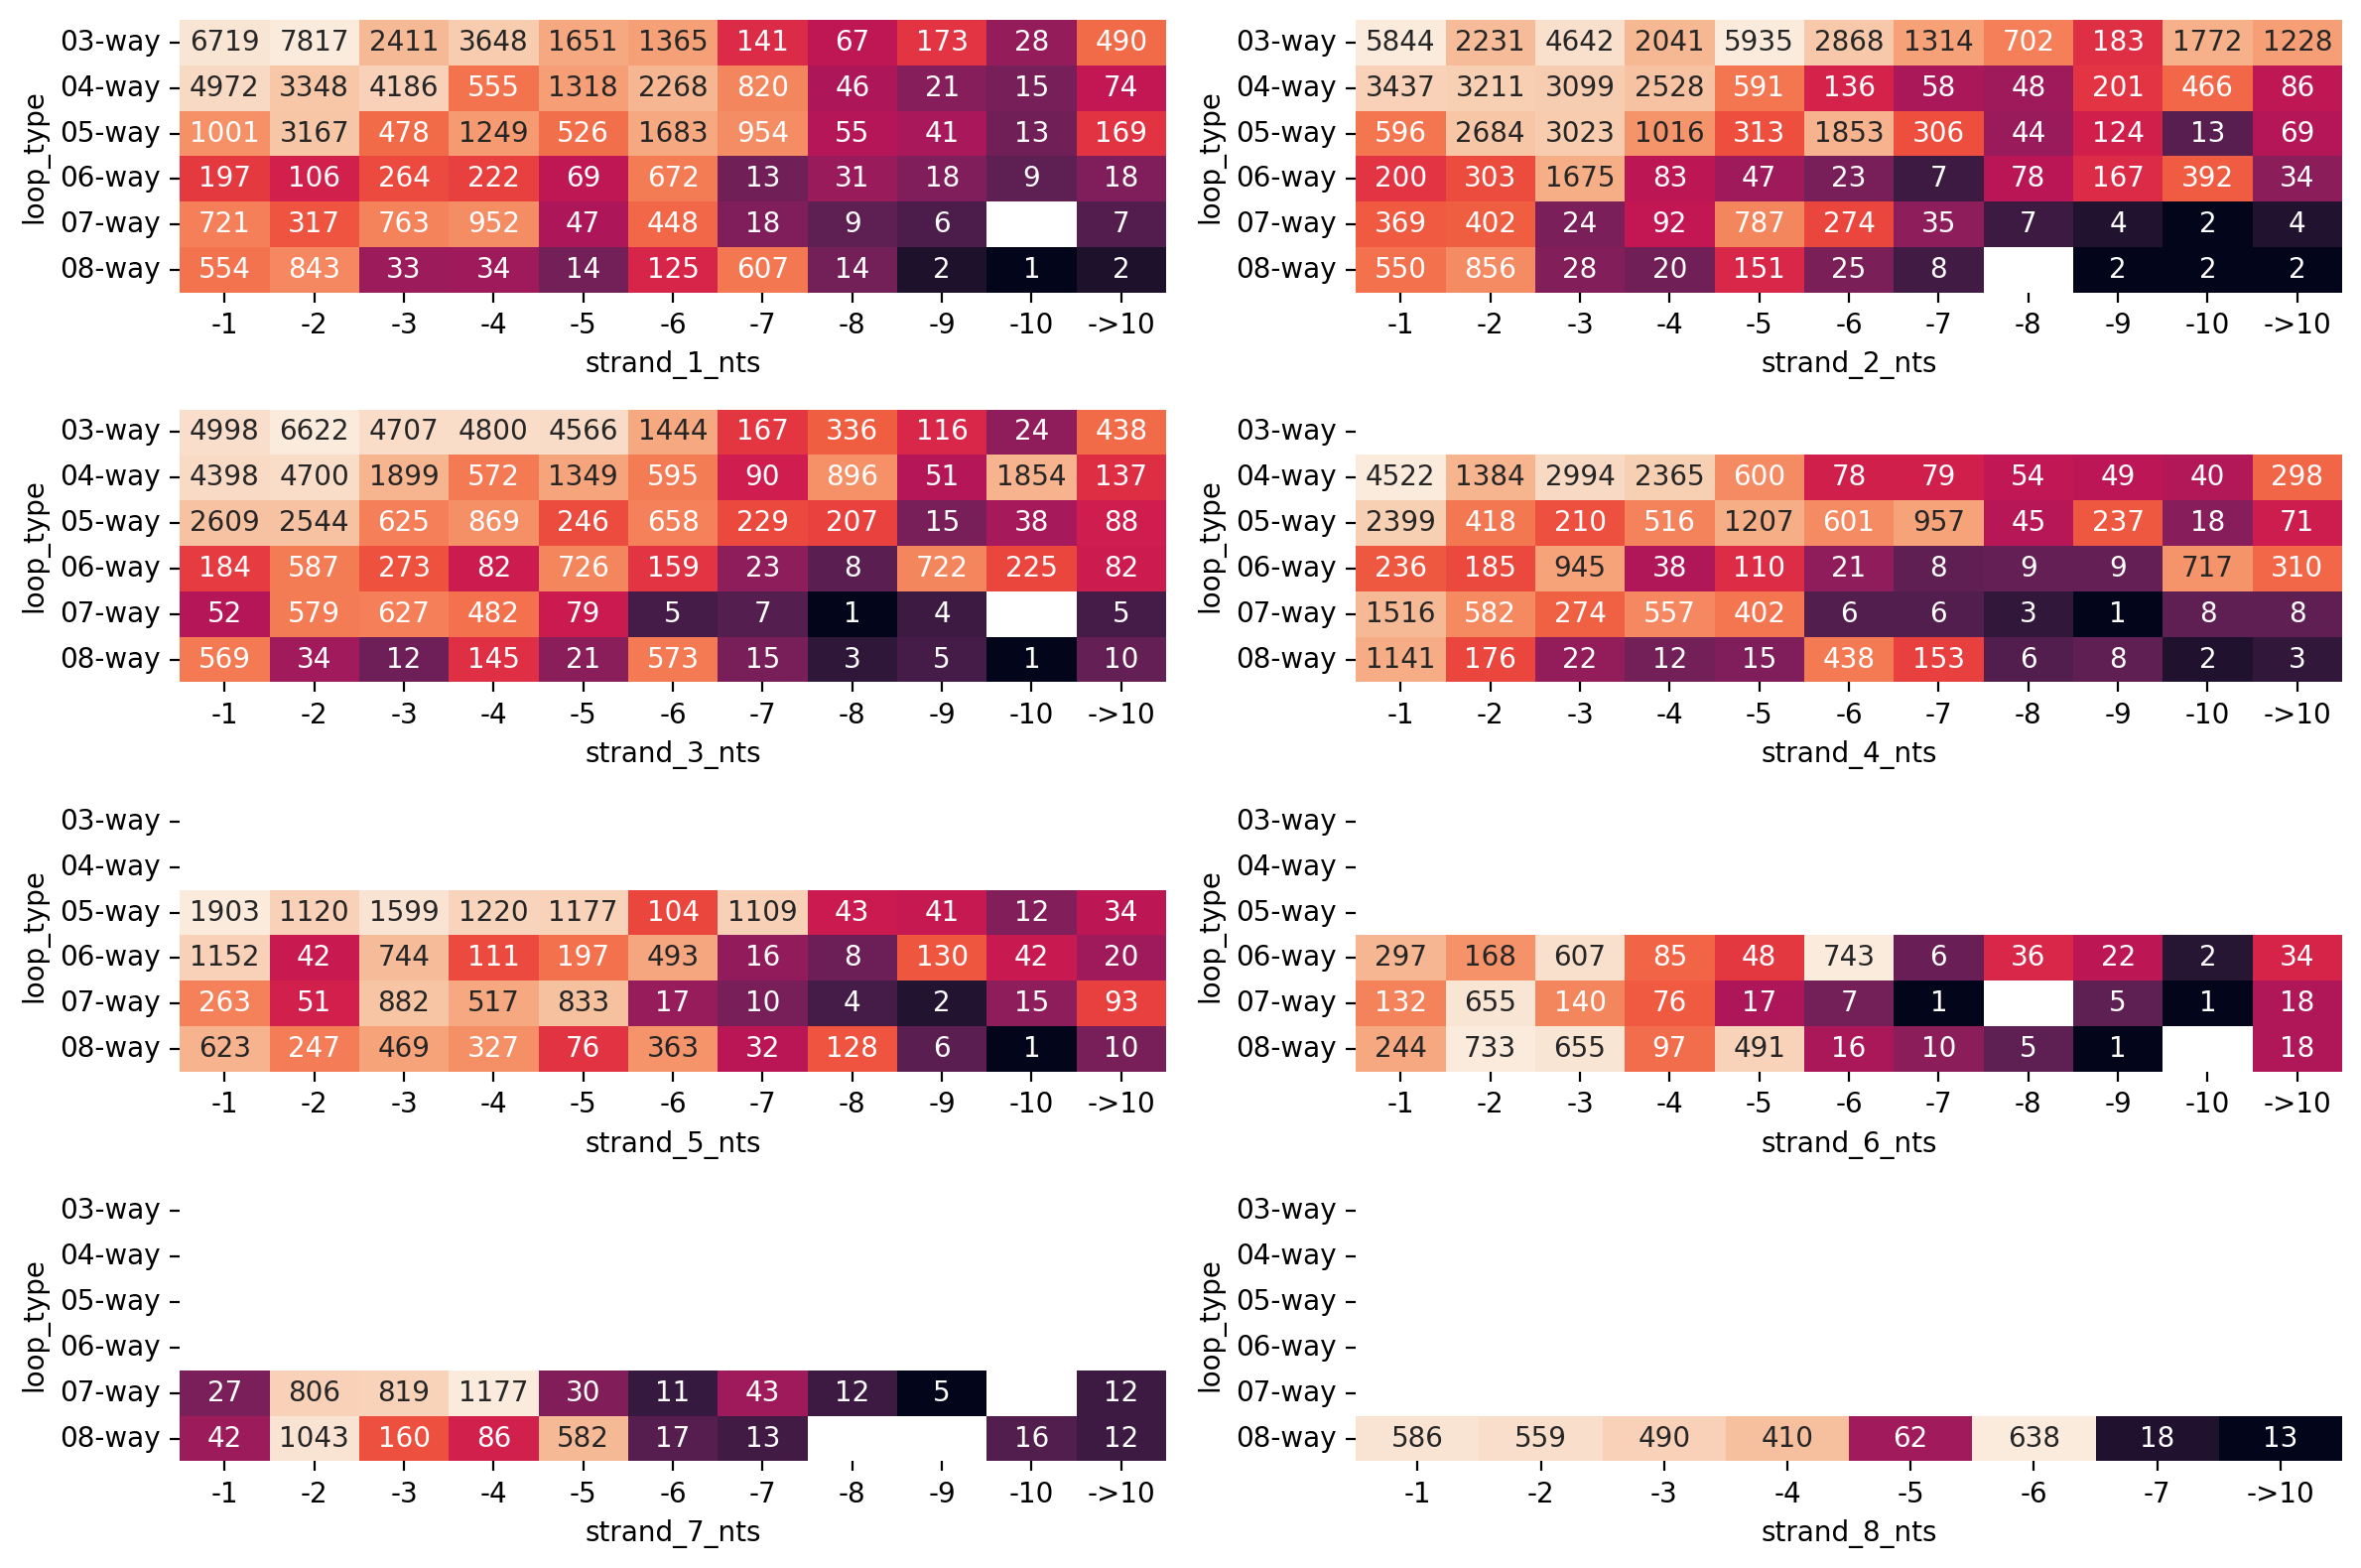

In [178]:
# (2) Verteilung der Strandlängen nach Looptyp:

fig, ax = plt.subplots(4, 2, figsize=(12, 8), dpi=200)

for idx, a in enumerate(ax.ravel()[:8]):
    
    key = f'strand_{idx+1}_nts'
    data = df[df[key]>0]
    data.loc[data[key]>10, key] = '>10'
    
    grouped = data.groupby(['loop_type', key]).count()
    matrix = grouped[['db_notation']].unstack(level=1)
    matrix = matrix.rename(columns={'db_notation': ''})
    
    sns.heatmap(matrix, norm=LogNorm(), annot=True, fmt='d', ax=a, cbar=False)
    _ = a.set_xlabel(key)
    a.set(ylabel=None)
    
plt.tight_layout()

In [216]:
# Funktion für Verteilung der Winkel, diskretisiere die Gradzahlen in 1°
# Schritten um analoge Plots zu den Heatmaps oben erzeugen zu können:

def angle_distribution(angle):

    fig, ax = plt.subplots(8, 1, figsize=(12, 12), dpi=200)

    for idx, a in enumerate(ax.ravel()[:8]):

        key = f'{angle}_{idx+1}'

        cutter = pd.cut(df[key], np.arange(0, 181, 1))
        grouped = df.groupby(['loop_type', cutter]).count()

        matrix = grouped[['db_notation']].unstack(level=1)
        matrix = matrix.rename(columns={'db_notation': ''})
        matrix = matrix.div(matrix.sum(axis=1), axis='rows')

        sns.heatmap(matrix, annot=False, fmt='d', ax=a, cbar=False, 
                    vmin=0, vmax=0.025)

        a.set(ylabel=None)
        a.set_title(key)
        a.axes.get_xaxis().set_visible(False)

    plt.tight_layout()

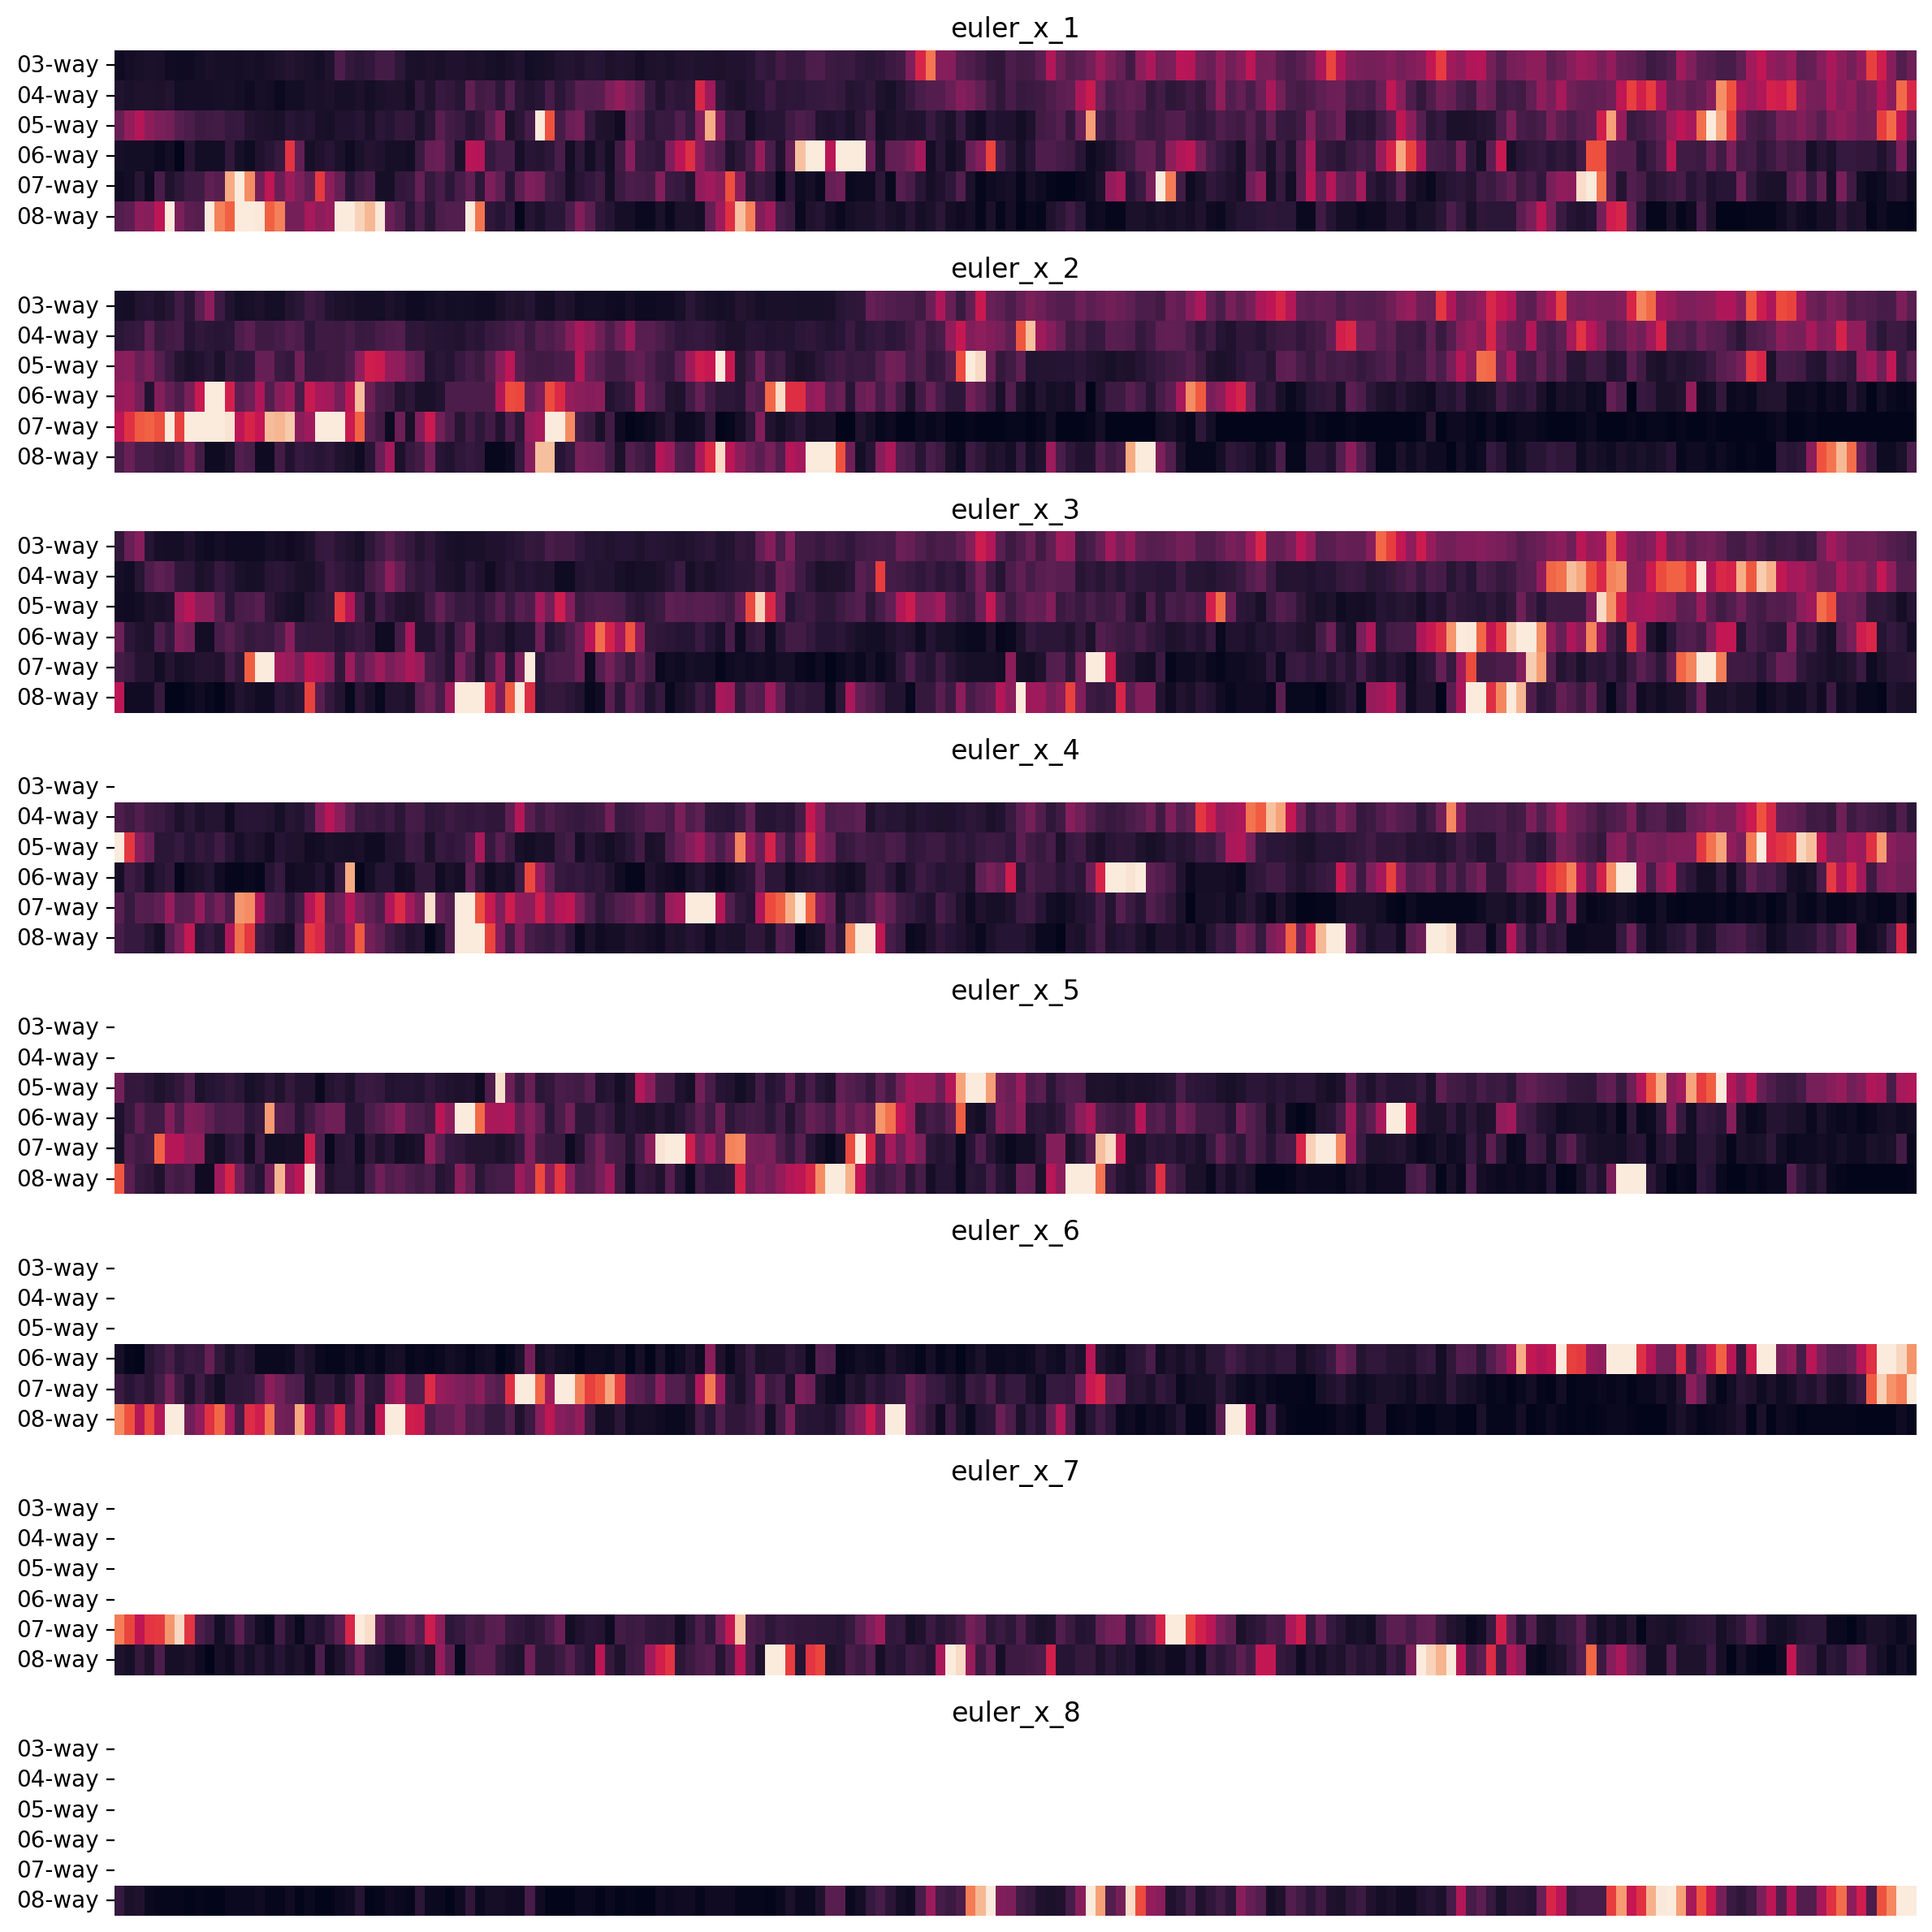

In [217]:
# (3.1) Verteilung der x Eulerwinkel nach Looptyp:
angle_distribution('euler_x')

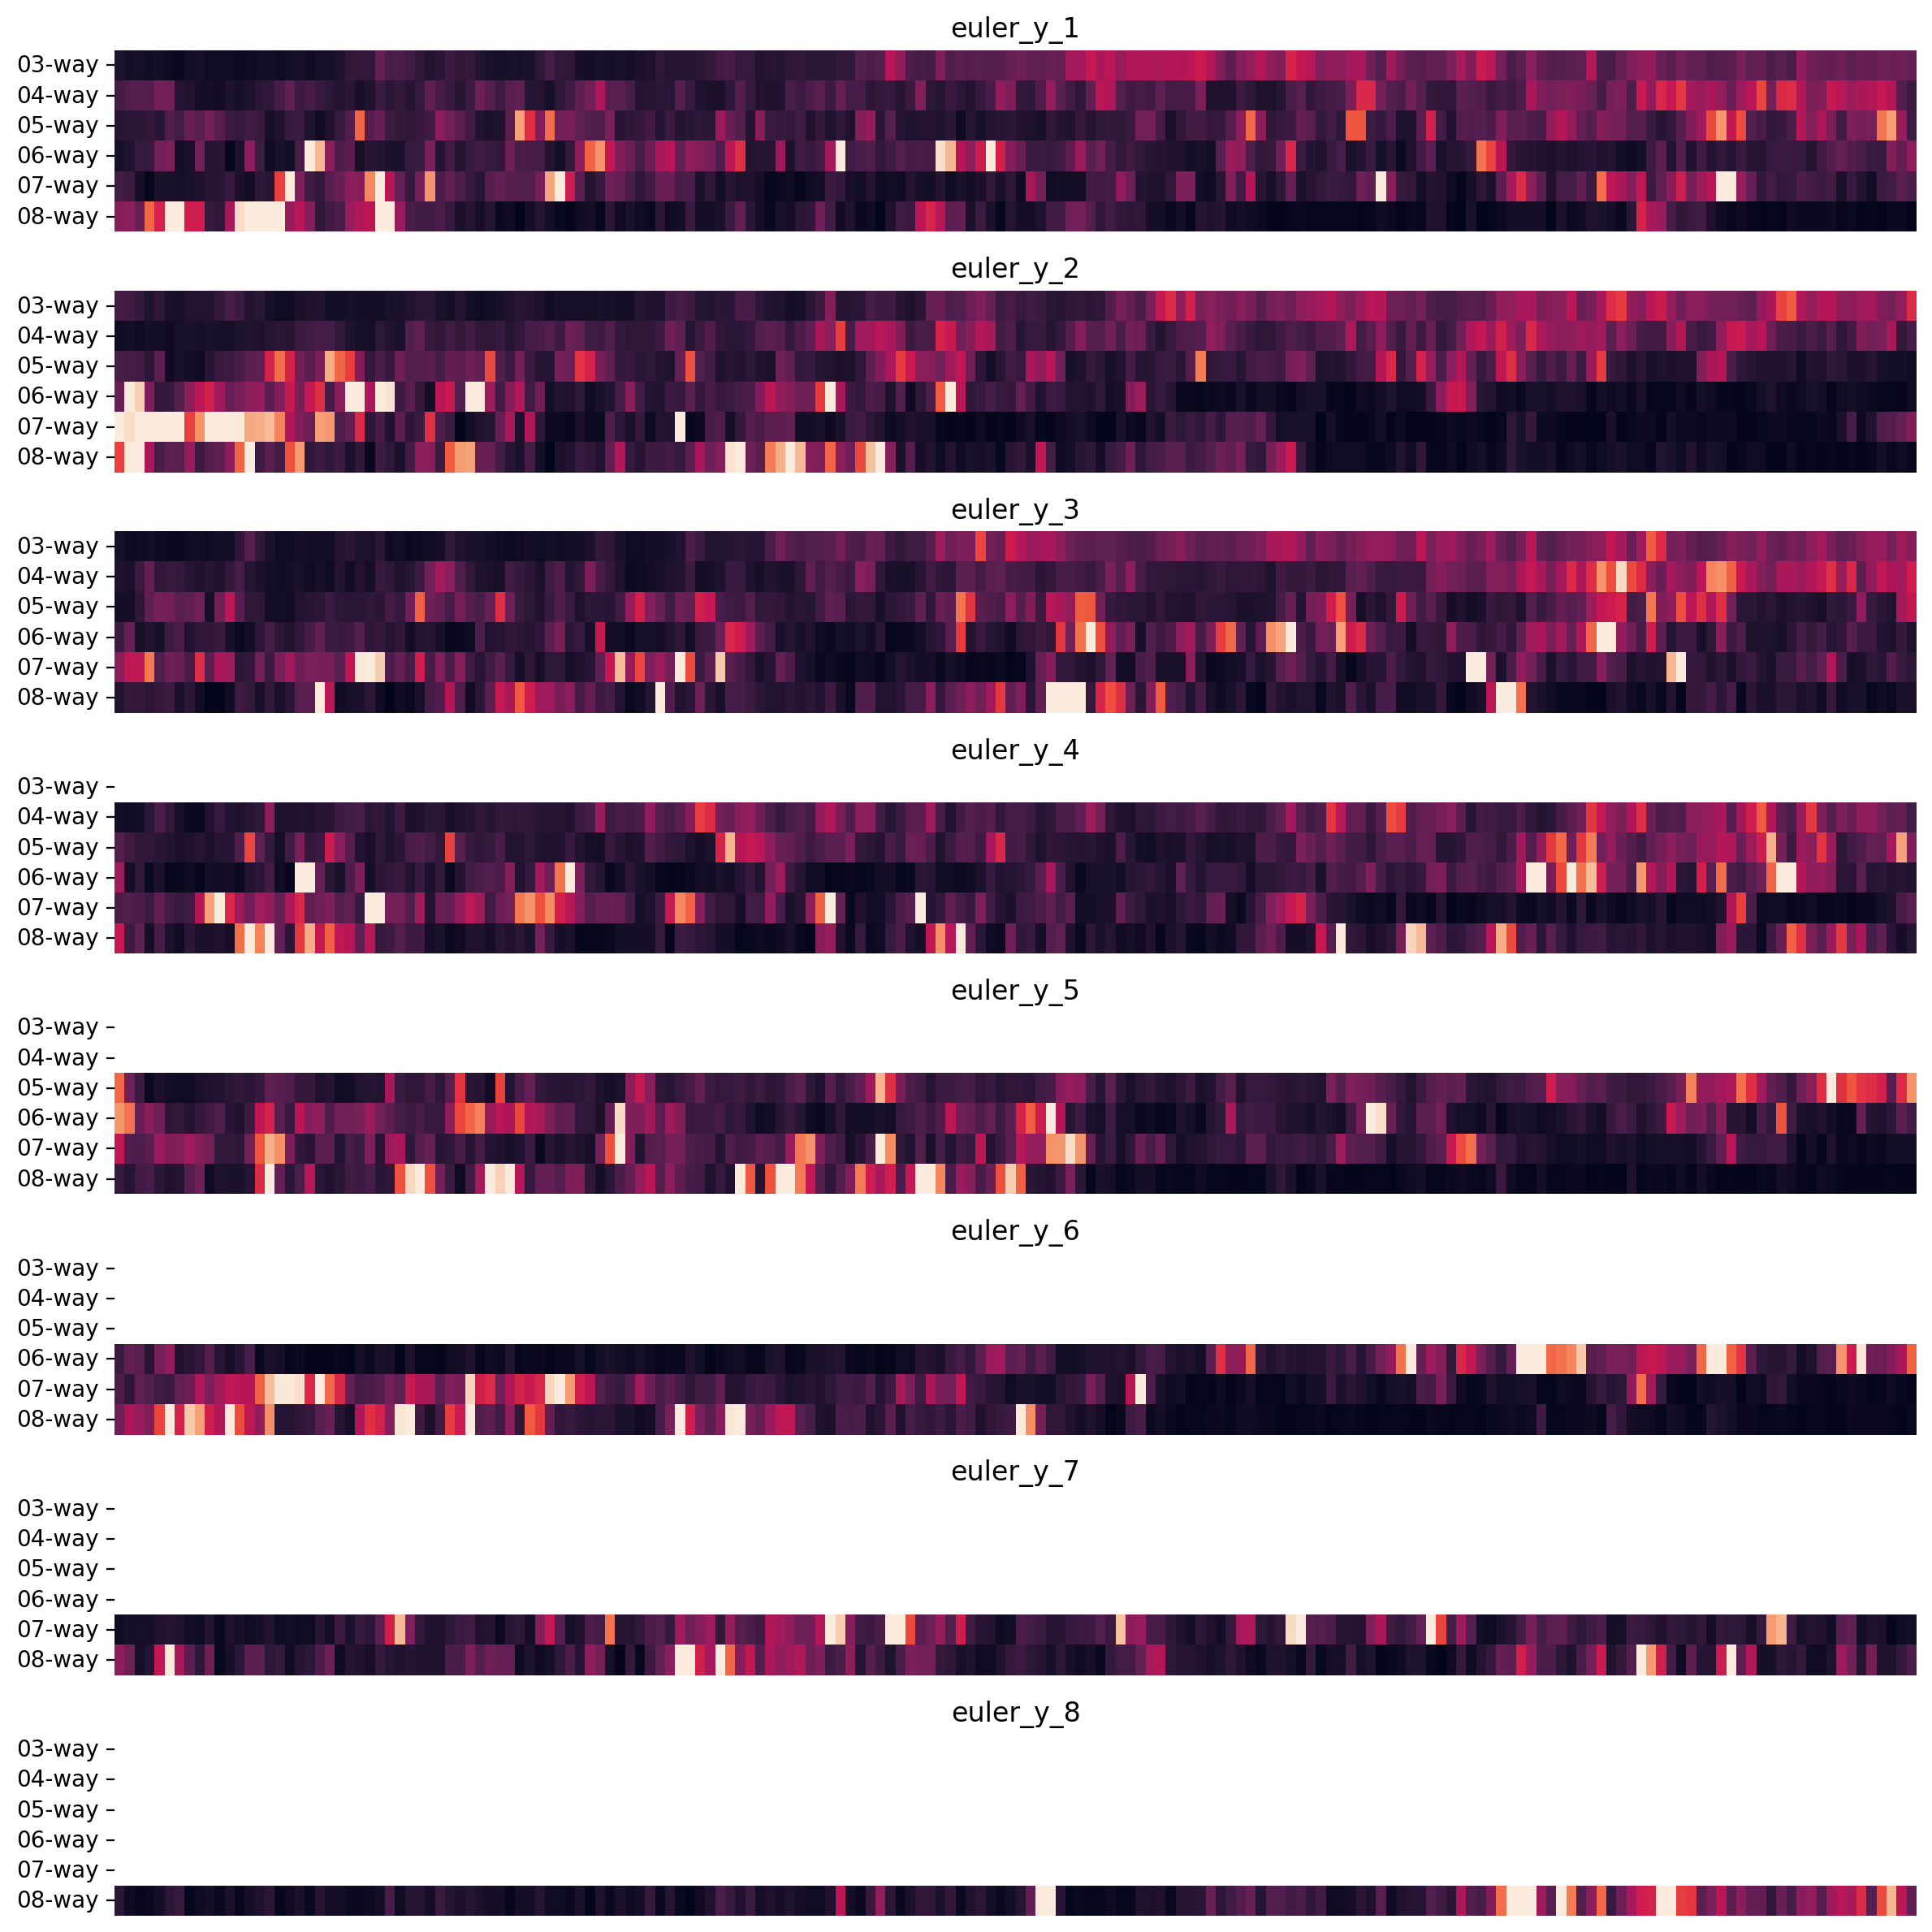

In [218]:
# (3.2) Verteilung der y Eulerwinkel nach Looptyp:
angle_distribution('euler_y')

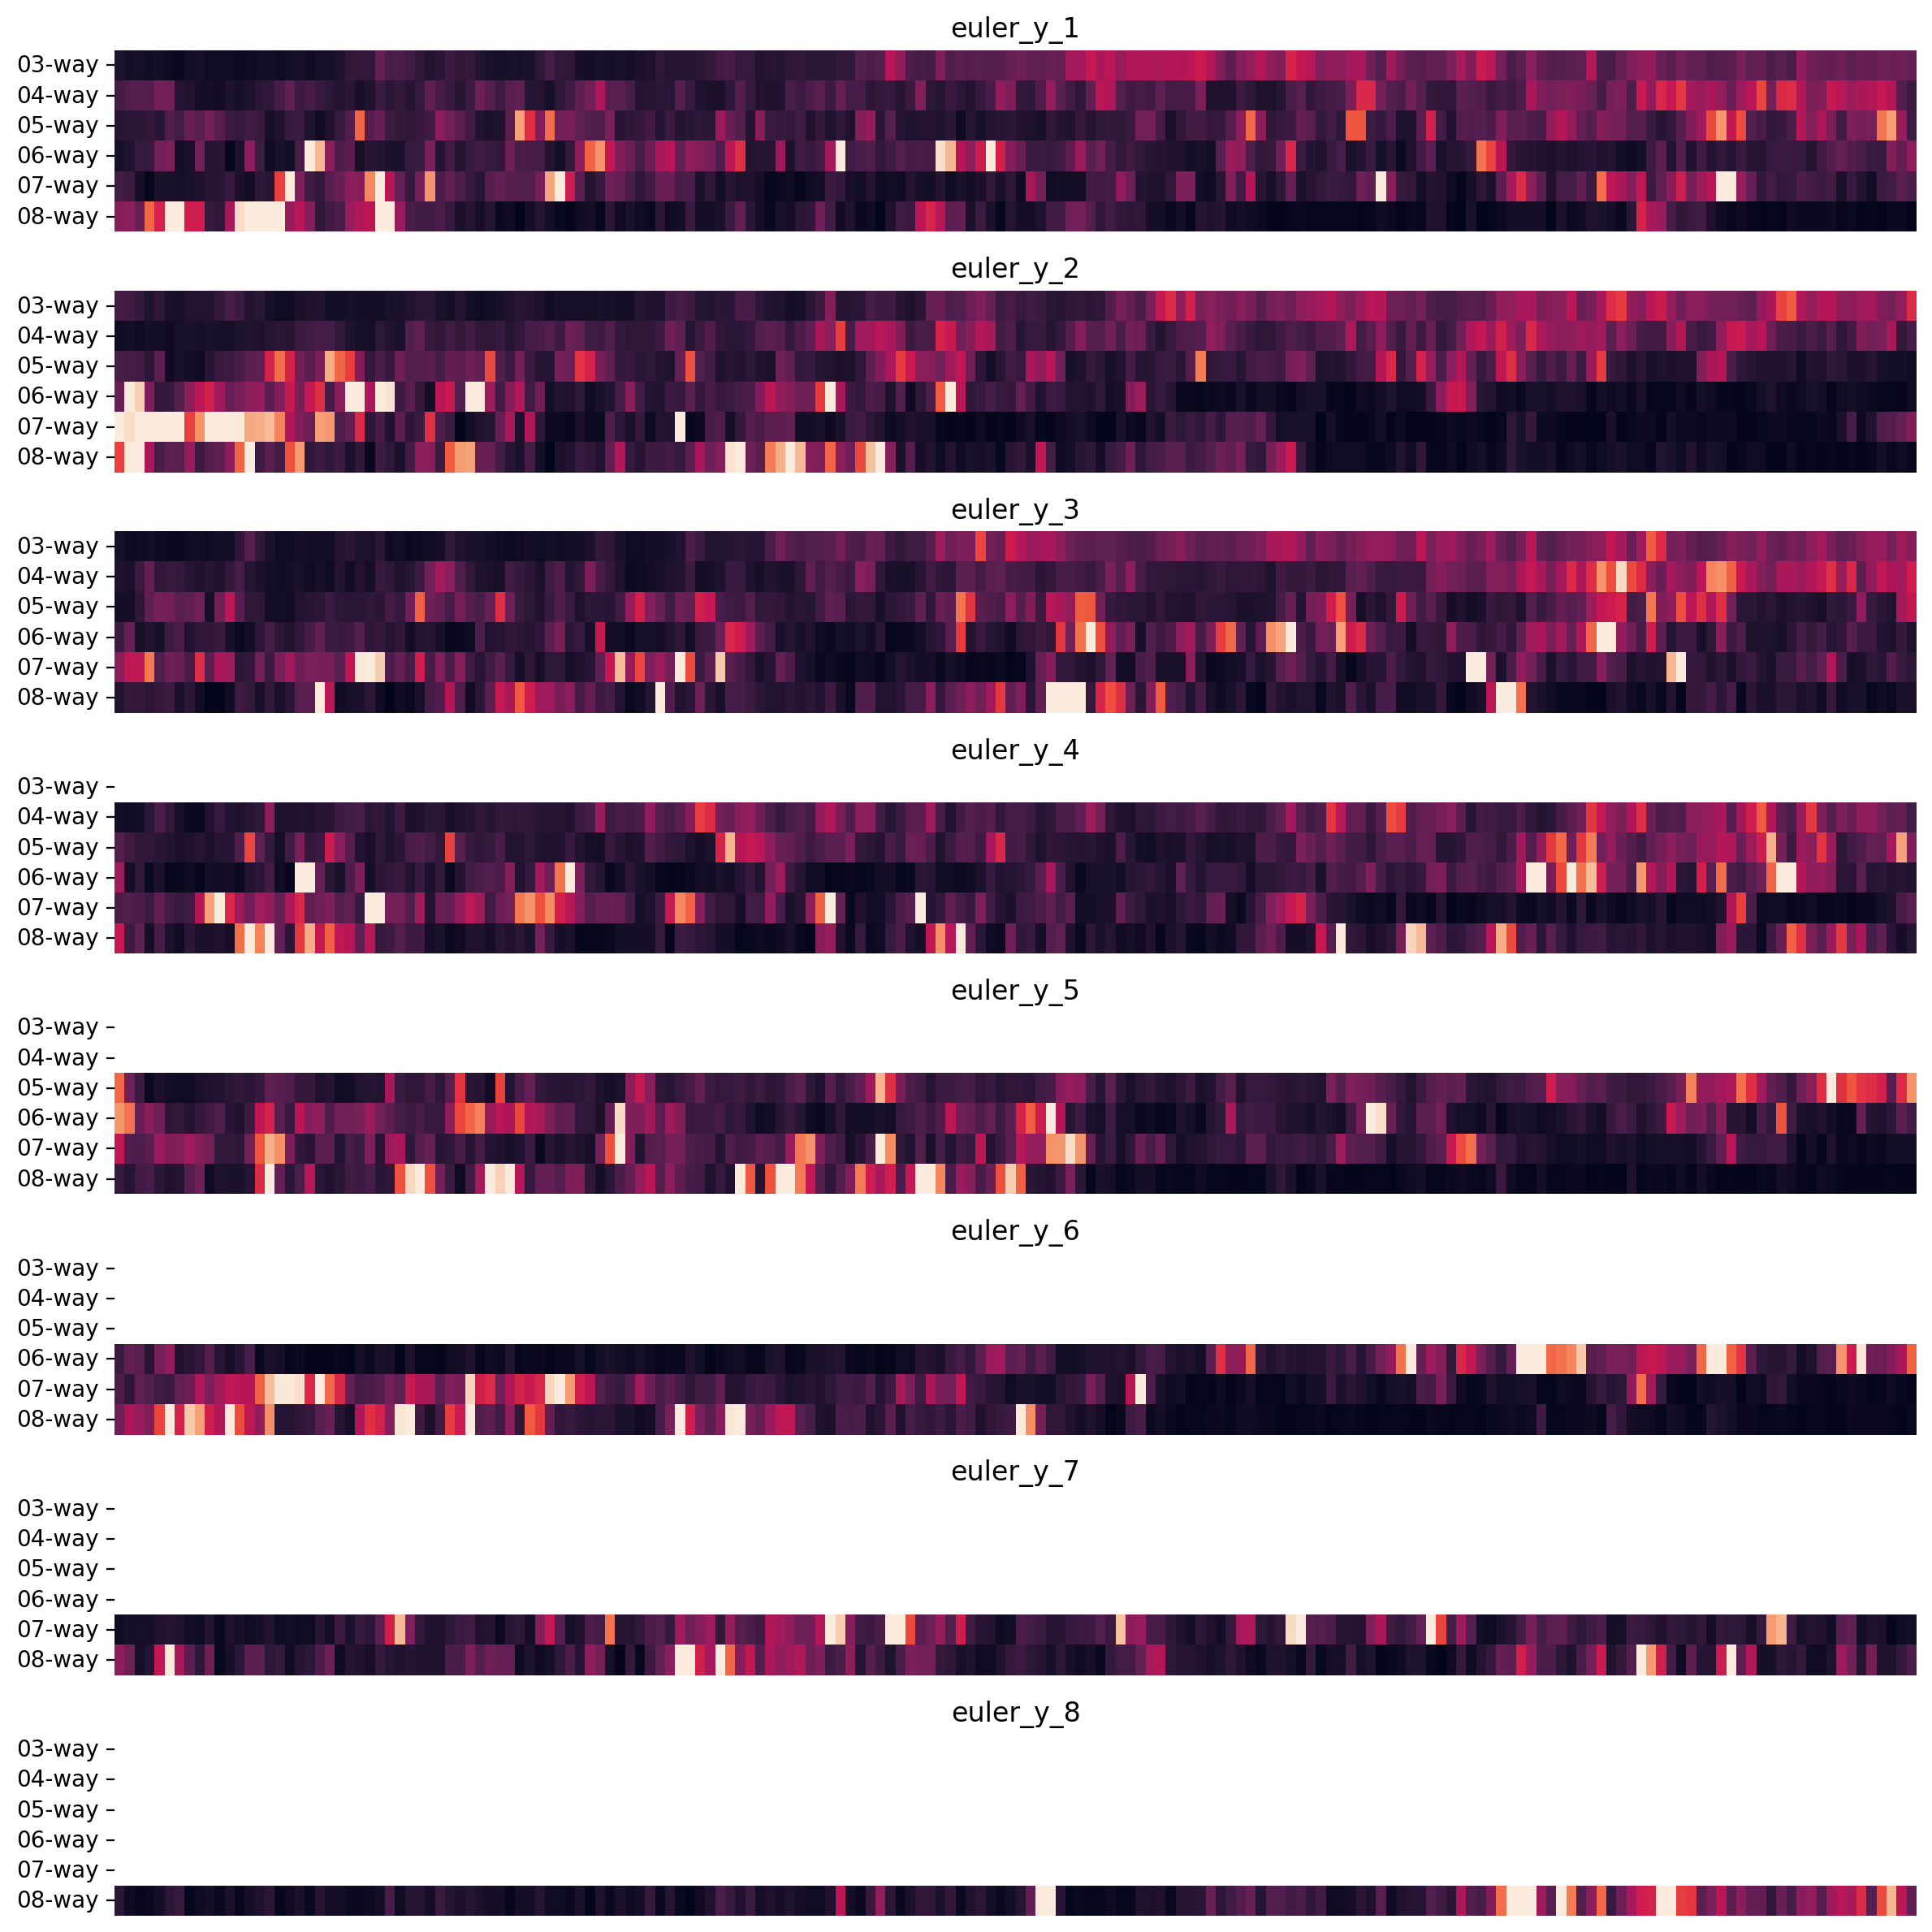

In [219]:
# (3.3) Verteilung der z Eulerwinkel nach Looptyp:
angle_distribution('euler_y')

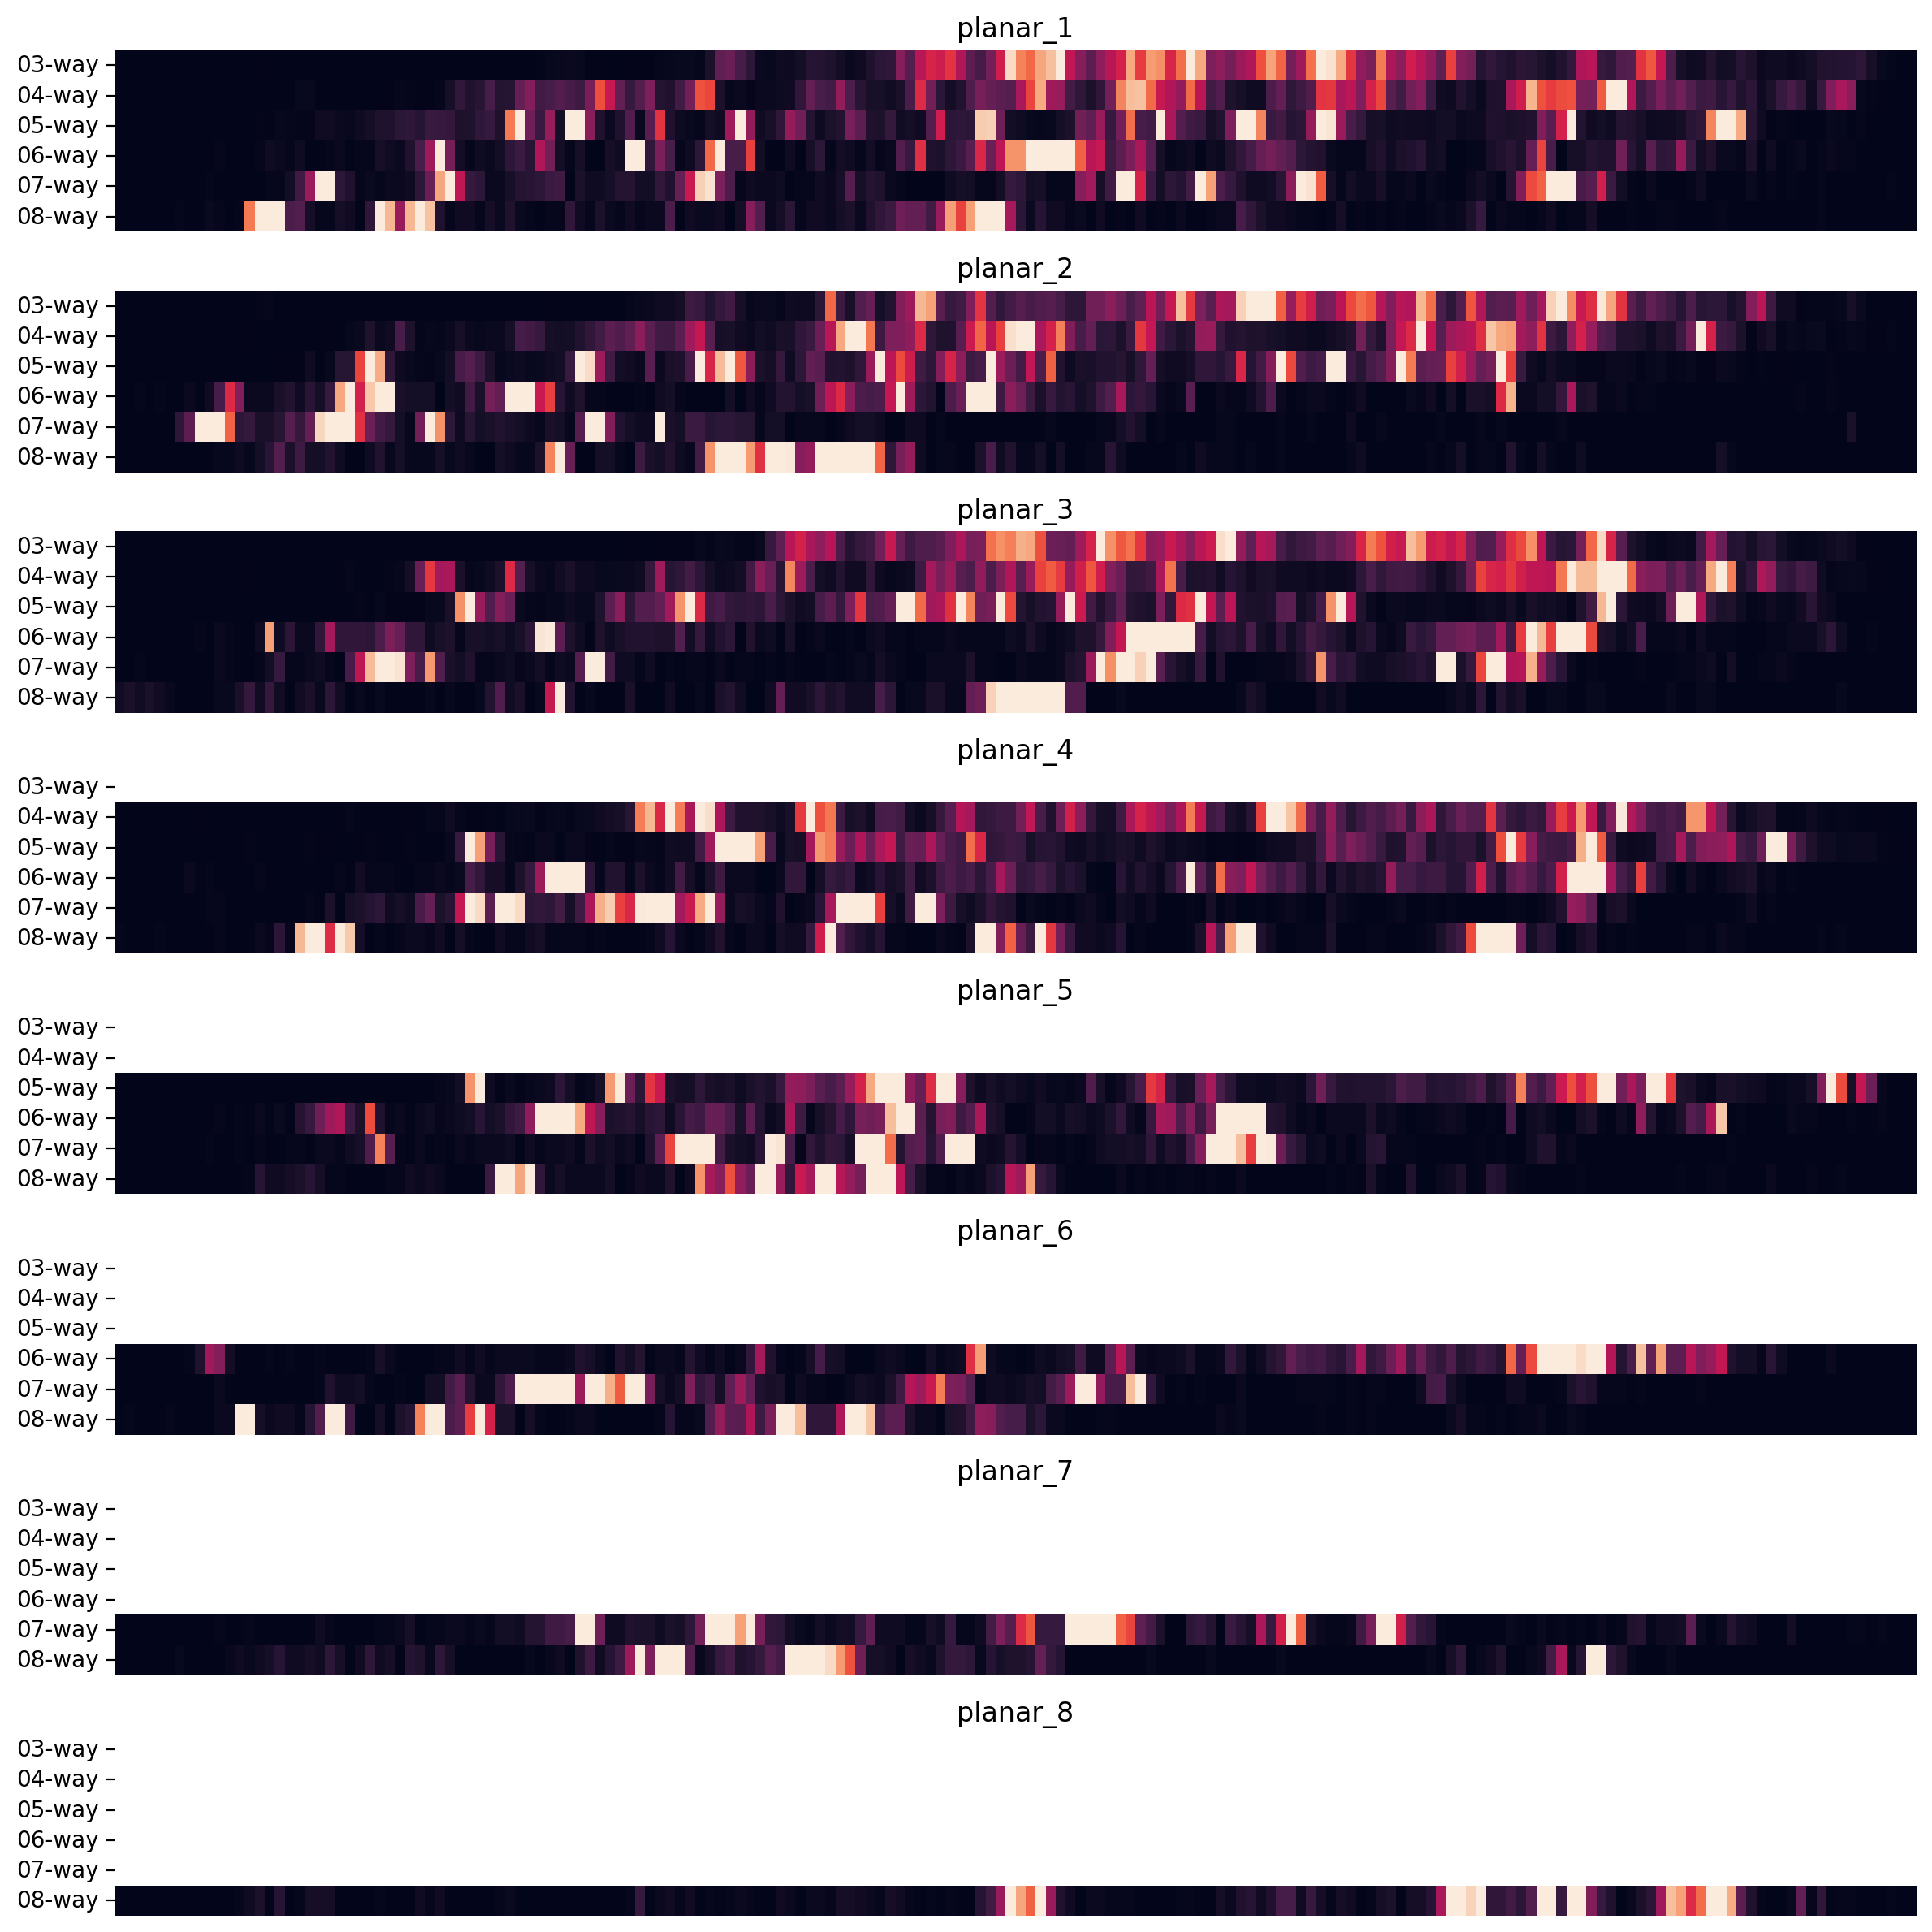

In [220]:
# (4) Verteilung der Planarwinkel nach Looptyp:
angle_distribution('planar')

Man kann in den Plots schon ein paar Muster erkennen, vielleicht kann irgendetwas davon noch interessant sein. \
Jetzt stellt sich die Frage, welche Gruppen und welche Feature weiter betrachtet werden sollen. 

Definiere eine Funktion um für einen Looptyp nur die relevanten Spalten und Zeilen zu erhalten:

In [293]:
def get_group(way=3, numeric=False):
    
    numerics = ['int8', 'int16', 'int64', 'float32', 'float64']
    
    way_df = df[df.loop_type==f'{way:02}-way']
    
    drop_cols = [c for c in way_df.columns if is_numeric_dtype(way_df[c])
                 and any(y<0 for y in way_df[c])]
    
    way_df = way_df.drop(drop_cols, axis=1)
    way_df = way_df.dropna(axis=1)
    
    if numeric:
        way_df = way_df.select_dtypes(include=numerics)
    
    return way_df

## Beziehungen der Feature in den Loop-Typ Gruppen

Wir können jetzt die Loop-Typen separat untersuchen. Wir müssen noch entscheiden welche wir dazu berücksichtigen. \
Wir können dann Beziehungen und Verteilungen der numerischen Feature weiter untersuchen um zu entscheiden welche relevant sind. \
Wir können auch die kategorischen und string Feature berücksichtigen, müssten diese aber erst transformieren, Daher sollte vorher klar sein welche davon sinnvoll sind. 

Ein nächster Schritt könnte z.B. sein, Korrelationen zu betrachten:

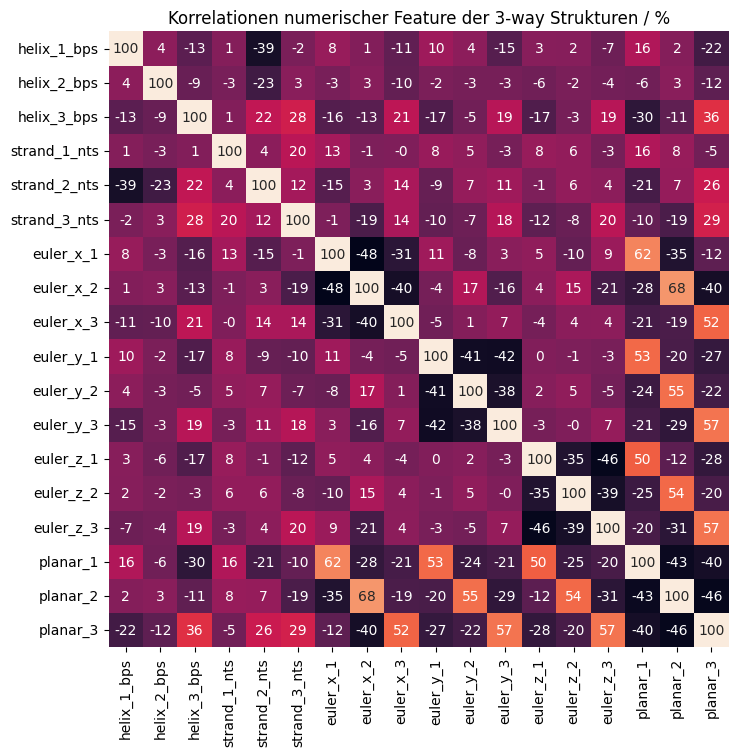

In [294]:
way3 = get_group(way=3, numeric=True)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(way3.corr(), annot=way3.corr()*100, cbar=False, fmt='.0f')
_ = ax.set_title('Korrelationen numerischer Feature der 3-way Strukturen / %')

Offensichtlich sind nicht alle Winkel unabhängig, wir sollten das berücksichtigen.

Weitere Untersuchungen der Feature erfolgen dann aber in eda_3.ipynb, dieses Notebook ist schon voll genug...